In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install optuna
!pip install shap
!pip install pytorch-tabnet
!pip install tabpfn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 7.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 692.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 

In [3]:
import numpy as np
import pandas as pd

import sklearn
import sklearn.metrics
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, auc, precision_score, recall_score, accuracy_score, balanced_accuracy_score, brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from math import sqrt
from scipy import stats as st
from random import randrange
from matplotlib import pyplot

from sklearn.linear_model import Lasso

from tabpfn import TabPFNClassifier
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

import optuna
from optuna.samplers import TPESampler

from sklearn.linear_model import LogisticRegression

import shap
from sklearn.inspection import PartialDependenceDisplay

import pickle

# Preparing Data

In [4]:
#Open csv file.

data = pd.read_csv('/content/drive/MyDrive/TQP-atSDH/final_data.csv', index_col = 0)

In [5]:
#Drop patients with unknown outcome of interest.

before = data.shape[0]
data = data[data['Total Length of Stay'].notna()]
after = data.shape[0]

excluded = before - after
print('Number of patients before exclusion: ', before)
print('Number of patients after exclusion: ', after)
print('Number of patients excluded with this criteria: ', excluded)

Number of patients before exclusion:  111183
Number of patients after exclusion:  110570
Number of patients excluded with this criteria:  613


In [6]:
#Exclude.

before = data.shape[0]
data = data[(data['Discharge Disposition'] != 'Deceased/Expired')]
data = data[(data['Discharge Disposition'] != 'Left against medical advice or discontinued care')]
after = data.shape[0]
excluded = before - after

print('Number of patients before exclusion: ', before)
print('Number of patients after exclusion: ', after)
print('Number of patients excluded with this criteria: ', excluded)

Number of patients before exclusion:  110570
Number of patients after exclusion:  104207
Number of patients excluded with this criteria:  6363


In [7]:
#Define outcome of interest.

print(data['Total Length of Stay'].quantile(0.80), '\n')

data.loc[data['Total Length of Stay'] <= data['Total Length of Stay'].quantile(0.80), 'OUTCOME'] = 0
data.loc[data['Total Length of Stay'] > data['Total Length of Stay'].quantile(0.80), 'OUTCOME'] = 1

print(data['OUTCOME'].value_counts(normalize=False, dropna=False))
print(data['OUTCOME'].value_counts(normalize=True, dropna=False))

7.0 

0.0    83534
1.0    20673
Name: OUTCOME, dtype: int64
0.0    0.801616
1.0    0.198384
Name: OUTCOME, dtype: float64


In [8]:
#Define predictor variables (x) and outcome of interest (y).

outcomes = ['Total Length of Stay', 'Discharge Disposition', 'Hospital Complication - Cardiac Arrest with CPR', 'Hospital Complication - Catheter-Associated Urinary Tract Infection (CAUTI)', 'Hospital Complication - Central Line-Associated Bloodstream Infection (CLABSI)', 'Hospital Complication - Catheter-Related Blood Stream Infection', 'Hospital Complication - Deep Surgical Site Infection', 'Hospital Complication - Delirium', 'Hospital Complication - Alcohol Withdrawal Syndrome', 'Hospital Complication - Deep Vein Thrombosis (DVT)', 'Hospital Complication - Pulmonary Embolism', 'Hospital Complication - Extremity Compartment Syndrome', 'Hospital Complication - Graft or Prosthesis or Flap Failure', 'Hospital Complication - Unplanned Intubation', 'Hospital Complication - Acute Kidney Injury', 'Hospital Complication - Myocardial Infarction', 'Hospital Complication - Organ or Space Surgical Site Infection', 'Hospital Complication - Osteomyelitis', 'Hospital Complication - Pneumonia', 'Hospital Complication - Pressure or Decubitis Ulcer', 'Hospital Complication - Acute Respiratory Distress Syndrome (ARDS)', 'Hospital Complication - Unplanned Return to the OR', 'Hospital Complication - Severe Sepsis', 'Hospital Complication - Stroke  or  CVA', 'Hospital Complication - Superficial Surgical Site Infection', 'Hospital Complication - Unplanned Admission to the ICU', 'Hospital Complication - Urinary Tract Infection', 'Hospital Complication - Ventilator-Associated Pneumonia (VAP)', 'Total ICU Length of Stay', 'OUTCOME']

x = data.drop(outcomes, axis = 1)
y = data['OUTCOME']

In [9]:
#Check data shapes.

print(y.shape)
print(x.shape)

(104207,)
(104207, 77)


In [10]:
#Split data into initial train set and test set in 90:10 ratio.

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)
  
#Describe initial train set and test set.

print("Number patients x_train dataset: ", x_train.shape[0])
print("Number patients y_train dataset: ", y_train.shape[0])
print("Number patients x_test dataset: ", x_test.shape[0])
print("Number patients y_test dataset: ", y_test.shape[0])

Number patients x_train dataset:  93786
Number patients y_train dataset:  93786
Number patients x_test dataset:  10421
Number patients y_test dataset:  10421


In [11]:
#Split initial train set into final train set and validation set in 60:30 ratio.

train_x, valid_x, train_y, valid_y = train_test_split(x_train, y_train, test_size = 1/3, random_state = 0)
  
#Describe train and validation sets.

print("Number patients train_x dataset: ", train_x.shape[0])
print("Number patients train_y dataset: ", train_y.shape[0])
print("Number patients valid_x dataset: ", valid_x.shape[0])
print("Number patients valid_y dataset: ", valid_y.shape[0])

Number patients train_x dataset:  62524
Number patients train_y dataset:  62524
Number patients valid_x dataset:  31262
Number patients valid_y dataset:  31262


In [12]:
#Describe outcome of interest before resampling.

print("Before resampling, counts of label '1': {}".format(sum(train_y == 1)))
print("Before resampling, counts of label '0': {} \n".format(sum(train_y == 0)))

Before resampling, counts of label '1': 12471
Before resampling, counts of label '0': 50053 



In [13]:
#Apply RUS.

from imblearn.under_sampling import RandomUnderSampler

resampler = RandomUnderSampler(random_state = 0)
train_x, train_y = resampler.fit_resample(train_x, train_y)

In [14]:
#Describe outcome of interest after resampling.

print("After resampling, counts of label '1': {}".format(sum(train_y == 1)))
print("After resampling, counts of label '0': {} \n".format(sum(train_y == 0)))

After resampling, counts of label '1': 12471
After resampling, counts of label '0': 12471 



In [15]:
#Define function for AUROC with 95% confidence intervals.

def auroc_ci(y_test, y_probs, positive=1, n_samples=1000, alpha=0.05):
    auroc_values = []
    for i in range(n_samples):
        y_test_bs, y_probs_bs = resample(y_test, y_probs)
        
        auroc = roc_auc_score(y_test_bs, y_probs_bs)
        auroc_values.append(auroc)
    
    mean_auroc = np.mean(auroc_values)
    std_auroc = np.std(auroc_values)
    
    lower_ci = mean_auroc - 1.96 * std_auroc
    upper_ci = mean_auroc + 1.96 * std_auroc
    
    return auroc, lower_ci, upper_ci

In [16]:
#Define z-value for other confidence intervals.

confidence = 0.95
z_value = st.norm.ppf((1 + confidence) / 2.0)

#Feature Selection

In [17]:
alpha = 0.025

lasso = Lasso(alpha=alpha, max_iter=10000, random_state=42)
lasso.fit(train_x, train_y)

selected_features_idx = np.nonzero(lasso.coef_)[0]

selected_features = train_x.columns[selected_features_idx]
print("Selected features:", selected_features)

train_x = train_x[selected_features]
valid_x = valid_x[selected_features]
x_test = x_test[selected_features]

Selected features: Index(['Age', 'Weight', 'Height', 'Systolic Blood Pressure', 'Pulse Rate',
       'Respiratory Rate', 'GCS - Verbal', 'Total GCS', 'Pupillary Response',
       'Bleeding Size', 'Days from Incident to ED or Hospital Arrival',
       'Blood Transfusion', 'Facility Bed Size'],
      dtype='object')


#TabPFN

No hyperparameter tuning is performed for TabPFN since the paper that introduced TabPFN claims no hyperparameter tuning is needed for it:


*We present TabPFN, a trained Transformer that can do supervised classification for small tabular datasets in less than a second, needs no hyperparameter tuning and is competitive with state-of-the-art classification methods.*

https://doi.org/10.48550/arXiv.2207.01848


In [18]:
#Fit TabPFN.

tabpfn = TabPFNClassifier(device='cpu', N_ensemble_configurations=2)

tabpfn_data = data.sample(frac=0.10, random_state=42)
tabpfn_x = tabpfn_data.drop(outcomes, axis = 1)
tabpfn_x = tabpfn_x[selected_features]
tabpfn_y = tabpfn_data['OUTCOME']
tabpfn_x_train, tabpfn_x_test, tabpfn_y_train, tabpfn_y_test = train_test_split(tabpfn_x, tabpfn_y, test_size = 0.1, random_state = 0)
tabpfn_train_x, tabpfn_valid_x, tabpfn_train_y, tabpfn_valid_y = train_test_split(tabpfn_x_train, tabpfn_y_train, test_size = 1/3, random_state = 0)
tabpfn_train_x, tabpfn_train_y = resampler.fit_resample(tabpfn_train_x, tabpfn_train_y)

tabpfn.fit(tabpfn_train_x, tabpfn_train_y, overwrite_warning = True)

We have to download the TabPFN, as there is no checkpoint at  /usr/local/lib/python3.10/dist-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt
It has about 100MB, so this might take a moment.
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


TabPFNClassifier(N_ensemble_configurations=2)

In [19]:
#Predict on the validation set, get predicted probabilities for calibration, and fit calibration function.

calib_probs_tabpfn = tabpfn.predict_proba(tabpfn_valid_x.values)

calib_model_tabpfn = LogisticRegression()
calib_model_tabpfn.fit(calib_probs_tabpfn, tabpfn_valid_y)

LogisticRegression()

In [20]:
#Make predictions on the test set based on the trained TabNet model.

preds_tabpfn = tabpfn.predict(tabpfn_x_test.values)

uncalibrated_probs_tabpfn = tabpfn.predict_proba(tabpfn_x_test.values)

probs_tabpfn = calib_model_tabpfn.predict_proba(uncalibrated_probs_tabpfn)
probs_tabpfn = probs_tabpfn[:, 1]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [21]:
#Evaluate TabNet model.

tabpfn_precision = round(precision_score(tabpfn_y_test, preds_tabpfn, average = 'weighted'), 3)
tabpfn_precision_ci_length = z_value * np.sqrt((tabpfn_precision * (1 - tabpfn_precision)) / y_test.shape[0])
tabpfn_precision_ci_lower = round((tabpfn_precision - tabpfn_precision_ci_length), 3)
tabpfn_precision_ci_upper = round((tabpfn_precision + tabpfn_precision_ci_length), 3)
tabpfn_precision_str = str(tabpfn_precision) + ' (' + str(tabpfn_precision_ci_lower) + ' - ' + str(tabpfn_precision_ci_upper) + ')'

tabpfn_recall = round(recall_score(tabpfn_y_test, preds_tabpfn, average = 'weighted'), 3)
tabpfn_recall_ci_length = z_value * np.sqrt((tabpfn_recall * (1 - tabpfn_recall)) / y_test.shape[0])
tabpfn_recall_ci_lower = round((tabpfn_recall - tabpfn_recall_ci_length), 3)
tabpfn_recall_ci_upper = round((tabpfn_recall + tabpfn_recall_ci_length), 3)
tabpfn_recall_str = str(tabpfn_recall) + ' (' + str(tabpfn_recall_ci_lower) + ' - ' + str(tabpfn_recall_ci_upper) + ')'

tabpfn_auprc = round(average_precision_score(tabpfn_y_test, probs_tabpfn, average = 'weighted'), 3)
tabpfn_auprc_ci_length = z_value * np.sqrt((tabpfn_auprc * (1 - tabpfn_auprc)) / y_test.shape[0])
tabpfn_auprc_ci_lower = round((tabpfn_auprc - tabpfn_auprc_ci_length), 3)
tabpfn_auprc_ci_upper = round((tabpfn_auprc + tabpfn_auprc_ci_length), 3)
tabpfn_auprc_str = str(tabpfn_auprc) + ' (' + str(tabpfn_auprc_ci_lower) + ' - ' + str(tabpfn_auprc_ci_upper) + ')'

tabpfn_accuracy = round(balanced_accuracy_score(tabpfn_y_test, preds_tabpfn), 3)
tabpfn_accuracy_ci_length = z_value * np.sqrt((tabpfn_accuracy * (1 - tabpfn_accuracy)) / y_test.shape[0])
tabpfn_accuracy_ci_lower = round((tabpfn_accuracy - tabpfn_accuracy_ci_length), 3)
tabpfn_accuracy_ci_upper = round((tabpfn_accuracy + tabpfn_accuracy_ci_length), 3)
tabpfn_accuracy_str = str(tabpfn_accuracy) + ' (' + str(tabpfn_accuracy_ci_lower) + ' - ' + str(tabpfn_accuracy_ci_upper) + ')'

tabpfn_auroc, tabpfn_auroc_ci_lower, tabpfn_auroc_ci_upper = auroc_ci(tabpfn_y_test, probs_tabpfn)
tabpfn_auroc = round(tabpfn_auroc, 3)
tabpfn_auroc_ci_lower = round(tabpfn_auroc_ci_lower, 3)
tabpfn_auroc_ci_upper = round(tabpfn_auroc_ci_upper, 3)
tabpfn_auroc_str = str(tabpfn_auroc) + ' (' + str(tabpfn_auroc_ci_lower) + ' - ' + str(tabpfn_auroc_ci_upper) + ')'

tabpfn_brier = round(brier_score_loss(tabpfn_y_test, probs_tabpfn), 3)
tabpfn_brier_ci_length = z_value * np.sqrt((tabpfn_brier * (1 - tabpfn_brier)) / y_test.shape[0])
tabpfn_brier_ci_lower = round((tabpfn_brier - tabpfn_brier_ci_length), 3)
tabpfn_brier_ci_upper = round((tabpfn_brier + tabpfn_brier_ci_length), 3)
tabpfn_brier_str = str(tabpfn_brier) + ' (' + str(tabpfn_brier_ci_lower) + ' - ' + str(tabpfn_brier_ci_upper) + ')'

tabpfn_results = [tabpfn_precision_str, tabpfn_recall_str, tabpfn_auprc_str, tabpfn_accuracy_str, tabpfn_auroc_str, tabpfn_brier_str]

print("Precision: ", (tabpfn_precision_str))
print("Recall: ", (tabpfn_recall_str))
print('AUPRC: ', (tabpfn_auprc_str))
print('Accuracy: ', (tabpfn_accuracy_str))
print('AUROC: ', (tabpfn_auroc_str))
print('Brier Score: ', (tabpfn_brier_str))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Precision:  0.772 (0.764 - 0.78)
Recall:  0.662 (0.653 - 0.671)
AUPRC:  0.334 (0.325 - 0.343)
Accuracy:  0.641 (0.632 - 0.65)
AUROC:  0.67 (0.669 - 0.739)
Brier Score:  0.144 (0.137 - 0.151)


In [22]:
#Recalculate precision recall curve for plotting purposes.

tabpfn_precision_curve, tabpfn_recall_curve, _ = precision_recall_curve(tabpfn_y_test, probs_tabpfn)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# TabNet

In [23]:
# Hyperparameter tuning for TabNet.

def objective(trial):

    param = {
        "n_d": trial.suggest_int("n_d", 8, 64),
        "n_a": trial.suggest_int("n_a", 8, 64),
        "n_steps": trial.suggest_int("n_steps", 1, 10),
        "gamma": trial.suggest_float("gamma", 1.0, 2.0),
        "n_independent": trial.suggest_int("n_independent", 1, 5),
        "n_shared": trial.suggest_int("n_shared", 1, 5),
        "lambda_sparse": trial.suggest_loguniform("lambda_sparse", 1e-6, 1e-3),
        "optimizer_params": {"lr": trial.suggest_loguniform("lr", 1e-5, 1e-2)},
        "seed": 31,
    }

    tabnet_clf = TabNetClassifier(**param)

    tabnet_clf.fit(
        train_x.values,
        train_y.values,
        eval_set=[(valid_x.values, valid_y.values)],
        eval_metric=["auc"],
        max_epochs=200,
        patience=20,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )

    preds = tabnet_clf.predict_proba(valid_x.values)[:, 1]
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc


if __name__ == "__main__":
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=31))
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    tabnet_params = {}

    for key, value in trial.params.items():
        tabnet_params[key] = value

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
[I 2023-05-19 13:30:43,427] A new study created in memory with name: no-name-ee6780b6-6de7-4dc0-b2ec-45a6db5448e1
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
Device used : cpu


epoch 0  | loss: 1.63066 | val_0_auc: 0.47509 |  0:00:10s
epoch 1  | loss: 1.60978 | val_0_auc: 0.45454 |  0:00:17s
epoch 2  | loss: 1.60361 | val_0_auc: 0.44676 |  0:00:28s
epoch 3  | loss: 1.55208 | val_0_auc: 0.48135 |  0:00:37s
epoch 4  | loss: 1.57575 | val_0_auc: 0.53014 |  0:00:47s
epoch 5  | loss: 1.56589 | val_0_auc: 0.49043 |  0:00:54s
epoch 6  | loss: 1.54586 | val_0_auc: 0.55769 |  0:01:02s
epoch 7  | loss: 1.49951 | val_0_auc: 0.56732 |  0:01:08s
epoch 8  | loss: 1.50448 | val_0_auc: 0.56509 |  0:01:16s
epoch 9  | loss: 1.49354 | val_0_auc: 0.46936 |  0:01:24s
epoch 10 | loss: 1.47259 | val_0_auc: 0.58039 |  0:01:30s
epoch 11 | loss: 1.46348 | val_0_auc: 0.45282 |  0:01:38s
epoch 12 | loss: 1.43643 | val_0_auc: 0.54909 |  0:01:45s
epoch 13 | loss: 1.45562 | val_0_auc: 0.45285 |  0:01:54s
epoch 14 | loss: 1.47067 | val_0_auc: 0.45991 |  0:02:01s
epoch 15 | loss: 1.44251 | val_0_auc: 0.45755 |  0:02:09s
epoch 16 | loss: 1.43595 | val_0_auc: 0.56463 |  0:02:15s
epoch 17 | los

Best weights from best epoch are automatically used!
[I 2023-05-19 13:34:52,827] Trial 0 finished with value: 0.5273340919381972 and parameters: {'n_d': 24, 'n_a': 62, 'n_steps': 8, 'gamma': 1.9868700030924629, 'n_independent': 2, 'n_shared': 1, 'lambda_sparse': 0.0005310328735364063, 'lr': 1.6066288228880885e-05}. Best is trial 0 with value: 0.5273340919381972.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
Device used : cpu


epoch 0  | loss: 0.91372 | val_0_auc: 0.49054 |  0:00:02s
epoch 1  | loss: 0.88899 | val_0_auc: 0.52559 |  0:00:04s
epoch 2  | loss: 0.86582 | val_0_auc: 0.49745 |  0:00:07s
epoch 3  | loss: 0.84468 | val_0_auc: 0.47149 |  0:00:10s
epoch 4  | loss: 0.81759 | val_0_auc: 0.50769 |  0:00:12s
epoch 5  | loss: 0.79694 | val_0_auc: 0.5261  |  0:00:15s
epoch 6  | loss: 0.77271 | val_0_auc: 0.54911 |  0:00:17s
epoch 7  | loss: 0.75337 | val_0_auc: 0.56237 |  0:00:19s
epoch 8  | loss: 0.7404  | val_0_auc: 0.57144 |  0:00:22s
epoch 9  | loss: 0.72398 | val_0_auc: 0.57538 |  0:00:25s
epoch 10 | loss: 0.7075  | val_0_auc: 0.57494 |  0:00:28s
epoch 11 | loss: 0.69831 | val_0_auc: 0.57762 |  0:00:30s
epoch 12 | loss: 0.69199 | val_0_auc: 0.57525 |  0:00:32s
epoch 13 | loss: 0.68446 | val_0_auc: 0.57455 |  0:00:34s
epoch 14 | loss: 0.68001 | val_0_auc: 0.57469 |  0:00:37s
epoch 15 | loss: 0.67571 | val_0_auc: 0.57626 |  0:00:40s
epoch 16 | loss: 0.67089 | val_0_auc: 0.58034 |  0:00:43s
epoch 17 | los

Best weights from best epoch are automatically used!
[I 2023-05-19 13:43:40,858] Trial 1 finished with value: 0.6667886225672324 and parameters: {'n_d': 12, 'n_a': 38, 'n_steps': 1, 'gamma': 1.3823932675263133, 'n_independent': 4, 'n_shared': 3, 'lambda_sparse': 1.354780454607063e-06, 'lr': 3.826995629452713e-05}. Best is trial 1 with value: 0.6667886225672324.


Number of finished trials: 2
Best trial:
  Value: 0.6667886225672324
  Params: 
    n_d: 12
    n_a: 38
    n_steps: 1
    gamma: 1.3823932675263133
    n_independent: 4
    n_shared: 3
    lambda_sparse: 1.354780454607063e-06
    lr: 3.826995629452713e-05


In [24]:
#See TabNet hyperparameters.

tabnet_params.pop('lr')

print(tabnet_params)

{'n_d': 12, 'n_a': 38, 'n_steps': 1, 'gamma': 1.3823932675263133, 'n_independent': 4, 'n_shared': 3, 'lambda_sparse': 1.354780454607063e-06}


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [25]:
#Fit TabNet.

tabnet = TabNetClassifier(**tabnet_params)

tabnet.fit(train_x.values, train_y.values)

Device used : cpu
No early stopping will be performed, last training weights will be used.


epoch 0  | loss: 0.64378 |  0:00:01s
epoch 1  | loss: 0.60579 |  0:00:03s
epoch 2  | loss: 0.5973  |  0:00:05s
epoch 3  | loss: 0.59086 |  0:00:07s
epoch 4  | loss: 0.5882  |  0:00:09s
epoch 5  | loss: 0.5839  |  0:00:10s
epoch 6  | loss: 0.58113 |  0:00:12s
epoch 7  | loss: 0.5811  |  0:00:13s
epoch 8  | loss: 0.58096 |  0:00:15s
epoch 9  | loss: 0.578   |  0:00:16s
epoch 10 | loss: 0.57718 |  0:00:18s
epoch 11 | loss: 0.5777  |  0:00:20s
epoch 12 | loss: 0.57497 |  0:00:22s
epoch 13 | loss: 0.5755  |  0:00:24s
epoch 14 | loss: 0.57519 |  0:00:26s
epoch 15 | loss: 0.57355 |  0:00:27s
epoch 16 | loss: 0.57238 |  0:00:28s
epoch 17 | loss: 0.5717  |  0:00:30s
epoch 18 | loss: 0.5719  |  0:00:31s
epoch 19 | loss: 0.57117 |  0:00:33s
epoch 20 | loss: 0.57171 |  0:00:35s
epoch 21 | loss: 0.56998 |  0:00:37s
epoch 22 | loss: 0.56807 |  0:00:39s
epoch 23 | loss: 0.57132 |  0:00:41s
epoch 24 | loss: 0.56903 |  0:00:42s
epoch 25 | loss: 0.56882 |  0:00:44s
epoch 26 | loss: 0.56556 |  0:00:45s
e

In [26]:
#Predict on the validation set, get predicted probabilities for calibration, and fit calibration function.

calib_probs_tabnet = tabnet.predict_proba(valid_x.values)

calib_model_tabnet = LogisticRegression()
calib_model_tabnet.fit(calib_probs_tabnet, valid_y)

LogisticRegression()

In [27]:
#Make predictions on the test set based on the trained TabNet model.

preds_tabnet = tabnet.predict(x_test.values)

uncalibrated_probs_tabnet = tabnet.predict_proba(x_test.values)

probs_tabnet = calib_model_tabnet.predict_proba(uncalibrated_probs_tabnet)
probs_tabnet = probs_tabnet[:, 1]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [28]:
#Evaluate TabNet model.

tabnet_precision = round(precision_score(y_test, preds_tabnet, average = 'weighted'), 3)
tabnet_precision_ci_length = z_value * np.sqrt((tabnet_precision * (1 - tabnet_precision)) / y_test.shape[0])
tabnet_precision_ci_lower = round((tabnet_precision - tabnet_precision_ci_length), 3)
tabnet_precision_ci_upper = round((tabnet_precision + tabnet_precision_ci_length), 3)
tabnet_precision_str = str(tabnet_precision) + ' (' + str(tabnet_precision_ci_lower) + ' - ' + str(tabnet_precision_ci_upper) + ')'

tabnet_recall = round(recall_score(y_test, preds_tabnet, average = 'weighted'), 3)
tabnet_recall_ci_length = z_value * np.sqrt((tabnet_recall * (1 - tabnet_recall)) / y_test.shape[0])
tabnet_recall_ci_lower = round((tabnet_recall - tabnet_recall_ci_length), 3)
tabnet_recall_ci_upper = round((tabnet_recall + tabnet_recall_ci_length), 3)
tabnet_recall_str = str(tabnet_recall) + ' (' + str(tabnet_recall_ci_lower) + ' - ' + str(tabnet_recall_ci_upper) + ')'

tabnet_auprc = round(average_precision_score(y_test, probs_tabnet, average = 'weighted'), 3)
tabnet_auprc_ci_length = z_value * np.sqrt((tabnet_auprc * (1 - tabnet_auprc)) / y_test.shape[0])
tabnet_auprc_ci_lower = round((tabnet_auprc - tabnet_auprc_ci_length), 3)
tabnet_auprc_ci_upper = round((tabnet_auprc + tabnet_auprc_ci_length), 3)
tabnet_auprc_str = str(tabnet_auprc) + ' (' + str(tabnet_auprc_ci_lower) + ' - ' + str(tabnet_auprc_ci_upper) + ')'

tabnet_accuracy = round(balanced_accuracy_score(y_test, preds_tabnet), 3)
tabnet_accuracy_ci_length = z_value * np.sqrt((tabnet_accuracy * (1 - tabnet_accuracy)) / y_test.shape[0])
tabnet_accuracy_ci_lower = round((tabnet_accuracy - tabnet_accuracy_ci_length), 3)
tabnet_accuracy_ci_upper = round((tabnet_accuracy + tabnet_accuracy_ci_length), 3)
tabnet_accuracy_str = str(tabnet_accuracy) + ' (' + str(tabnet_accuracy_ci_lower) + ' - ' + str(tabnet_accuracy_ci_upper) + ')'

tabnet_auroc, tabnet_auroc_ci_lower, tabnet_auroc_ci_upper = auroc_ci(y_test, probs_tabnet)
tabnet_auroc = round(tabnet_auroc, 3)
tabnet_auroc_ci_lower = round(tabnet_auroc_ci_lower, 3)
tabnet_auroc_ci_upper = round(tabnet_auroc_ci_upper, 3)
tabnet_auroc_str = str(tabnet_auroc) + ' (' + str(tabnet_auroc_ci_lower) + ' - ' + str(tabnet_auroc_ci_upper) + ')'

tabnet_brier = round(brier_score_loss(y_test, probs_tabnet), 3)
tabnet_brier_ci_length = z_value * np.sqrt((tabnet_brier * (1 - tabnet_brier)) / y_test.shape[0])
tabnet_brier_ci_lower = round((tabnet_brier - tabnet_brier_ci_length), 3)
tabnet_brier_ci_upper = round((tabnet_brier + tabnet_brier_ci_length), 3)
tabnet_brier_str = str(tabnet_brier) + ' (' + str(tabnet_brier_ci_lower) + ' - ' + str(tabnet_brier_ci_upper) + ')'

tabnet_results = [tabnet_precision_str, tabnet_recall_str, tabnet_auprc_str, tabnet_accuracy_str, tabnet_auroc_str, tabnet_brier_str]

print("Precision: ", (tabnet_precision_str))
print("Recall: ", (tabnet_recall_str))
print('AUPRC: ', (tabnet_auprc_str))
print('Accuracy: ', (tabnet_accuracy_str))
print('AUROC: ', (tabnet_auroc_str))
print('Brier Score: ', (tabnet_brier_str))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Precision:  0.774 (0.766 - 0.782)
Recall:  0.635 (0.626 - 0.644)
AUPRC:  0.345 (0.336 - 0.354)
Accuracy:  0.645 (0.636 - 0.654)
AUROC:  0.698 (0.69 - 0.713)
Brier Score:  0.143 (0.136 - 0.15)


In [29]:
#Recalculate precision recall curve for plotting purposes.

tabnet_precision_curve, tabnet_recall_curve, _ = precision_recall_curve(y_test, probs_tabnet)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# XGBoost

In [30]:
#Hyperparameter tuning for XGBoost.

def objective(trial):

    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "seed": 31,
        "verbosity": 0,
        "objective":  trial.suggest_categorical("objective", ["binary:logistic"]),
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "max_depth" : trial.suggest_int("max_depth", 1, 9),
        "eta" : trial.suggest_float("eta", 1e-8, 1.0, log=True),
        "gamma" : trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy" : trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }


    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    
    bst = xgb.train(param, dtrain, evals=[(dvalid, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize", sampler = TPESampler(seed=31)
    )
    study.optimize(objective, n_trials=100)
    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    xgb_params = {}
    
    for key, value in trial.params.items():
        xgb_params[key] = value

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
[I 2023-05-19 13:46:39,430] A new study created in memory with name: no-name-e4b2516c-35d4-4bf7-84a1-ebb9575e384e


[0]	validation-auc:0.74000
[1]	validation-auc:0.74263


APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
_PyDriveImportHook.find_spec() not found; falling back to find_module()
_OpenCVImportHook.find_spec() not found; falling back to find_module()
_BokehImportHook.find_spec() not found; falling back to find_module()
_AltairImportHook.find_spec() not found; falling back to find_module()


[2]	validation-auc:0.74739
[3]	validation-auc:0.74757
[4]	validation-auc:0.74729
[5]	validation-auc:0.74602
[6]	validation-auc:0.74463
[7]	validation-auc:0.74196
[8]	validation-auc:0.74165
[9]	validation-auc:0.73986


[I 2023-05-19 13:46:39,947] Trial 0 finished with value: 0.6705955336542531 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.9428110874325094e-06, 'alpha': 0.4622155288125666, 'max_depth': 7, 'eta': 0.7851633597929335, 'gamma': 4.627257790053709e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.6705955336542531.


[0]	validation-auc:0.50000
[1]	validation-auc:0.62802
[2]	validation-auc:0.69467
[3]	validation-auc:0.71379
[4]	validation-auc:0.72329
[5]	validation-auc:0.72005
[6]	validation-auc:0.72302
[7]	validation-auc:0.72522
[8]	validation-auc:0.72556
[9]	validation-auc:0.72545


[I 2023-05-19 13:46:40,295] Trial 1 finished with value: 0.6628128368570879 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.540855010579091e-08, 'alpha': 4.005546508605542e-08, 'max_depth': 5, 'eta': 5.190362998186933e-08, 'gamma': 1.1458984717217304e-05, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6705955336542531.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.62802
[3]	validation-auc:0.65306
[4]	validation-auc:0.69467
[5]	validation-auc:0.71379
[6]	validation-auc:0.71379
[7]	validation-auc:0.72329
[8]	validation-auc:0.72329
[9]	validation-auc:0.72005


[I 2023-05-19 13:46:40,665] Trial 2 finished with value: 0.6628128368570879 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.2472451918309905e-08, 'alpha': 3.5833391127860344e-07, 'max_depth': 5, 'eta': 3.166549087607022e-08, 'gamma': 2.4018078289549153e-06, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6705955336542531.


[0]	validation-auc:0.73737
[1]	validation-auc:0.73738
[2]	validation-auc:0.73742
[3]	validation-auc:0.73746
[4]	validation-auc:0.73759
[5]	validation-auc:0.73753
[6]	validation-auc:0.73770
[7]	validation-auc:0.73765
[8]	validation-auc:0.73768
[9]	validation-auc:0.73769


[I 2023-05-19 13:46:41,268] Trial 3 finished with value: 0.6658492187128082 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.3853144759016545e-06, 'alpha': 1.810306176116705e-05, 'max_depth': 8, 'eta': 0.00011313716853812925, 'gamma': 1.431538552328043e-06, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.6705955336542531.


[0]	validation-auc:0.73999
[1]	validation-auc:0.73984
[2]	validation-auc:0.73984
[3]	validation-auc:0.73991
[4]	validation-auc:0.73985
[5]	validation-auc:0.73991
[6]	validation-auc:0.73991
[7]	validation-auc:0.73991
[8]	validation-auc:0.73991
[9]	validation-auc:0.73991


[I 2023-05-19 13:46:41,753] Trial 4 finished with value: 0.6689516098477734 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.981512489677599e-07, 'alpha': 8.673160455297617e-07, 'max_depth': 7, 'eta': 1.1789142339699406e-05, 'gamma': 4.915182221710387e-05, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6705955336542531.


[0]	validation-auc:0.50000
[1]	validation-auc:0.56558
[2]	validation-auc:0.56558
[3]	validation-auc:0.56558
[4]	validation-auc:0.56558
[5]	validation-auc:0.56558


[I 2023-05-19 13:46:41,885] Trial 5 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.72571
[1]	validation-auc:0.72628
[2]	validation-auc:0.73209
[3]	validation-auc:0.73435
[4]	validation-auc:0.73367
[5]	validation-auc:0.73433


[I 2023-05-19 13:46:42,103] Trial 6 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000


[I 2023-05-19 13:46:42,261] Trial 7 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73984
[1]	validation-auc:0.73984
[2]	validation-auc:0.73983
[3]	validation-auc:0.73991
[4]	validation-auc:0.73986
[5]	validation-auc:0.73986
[6]	validation-auc:0.73986
[7]	validation-auc:0.73986
[8]	validation-auc:0.73990
[9]	validation-auc:0.73991


[I 2023-05-19 13:46:42,750] Trial 8 finished with value: 0.6689516098477734 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.012396727001275e-07, 'alpha': 4.813416353568083e-07, 'max_depth': 7, 'eta': 7.282914217164152e-06, 'gamma': 1.2485590633659993e-05, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.6705955336542531.


[0]	validation-auc:0.71312
[1]	validation-auc:0.71312
[2]	validation-auc:0.71312
[3]	validation-auc:0.71312
[4]	validation-auc:0.71312
[5]	validation-auc:0.71312


[I 2023-05-19 13:46:42,958] Trial 9 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73584
[1]	validation-auc:0.74003
[2]	validation-auc:0.74290
[3]	validation-auc:0.74435
[4]	validation-auc:0.74794
[5]	validation-auc:0.74577
[6]	validation-auc:0.74598
[7]	validation-auc:0.74584
[8]	validation-auc:0.74570
[9]	validation-auc:0.74574


[I 2023-05-19 13:46:43,615] Trial 10 finished with value: 0.6760803484960878 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00014875469166774263, 'alpha': 0.08891248184691007, 'max_depth': 9, 'eta': 0.3421809577611061, 'gamma': 0.012767891809519486, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.6760803484960878.


[0]	validation-auc:0.73326
[1]	validation-auc:0.74220
[2]	validation-auc:0.74511
[3]	validation-auc:0.74624
[4]	validation-auc:0.74790
[5]	validation-auc:0.74805
[6]	validation-auc:0.74671
[7]	validation-auc:0.74764
[8]	validation-auc:0.74756
[9]	validation-auc:0.74678


[I 2023-05-19 13:46:44,261] Trial 11 finished with value: 0.6759532723586823 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.24005465481427e-05, 'alpha': 0.5044407594011535, 'max_depth': 9, 'eta': 0.38585538428714167, 'gamma': 0.01566808236910022, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.6760803484960878.


[0]	validation-auc:0.73518
[1]	validation-auc:0.73835
[2]	validation-auc:0.73963
[3]	validation-auc:0.74054
[4]	validation-auc:0.74100
[5]	validation-auc:0.74227
[6]	validation-auc:0.74328
[7]	validation-auc:0.74422
[8]	validation-auc:0.74483
[9]	validation-auc:0.74536


[I 2023-05-19 13:46:44,903] Trial 12 finished with value: 0.675240737843439 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0001837478808869203, 'alpha': 0.2697778512538622, 'max_depth': 9, 'eta': 0.033744944689154524, 'gamma': 0.054728976284208045, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.6760803484960878.


[0]	validation-auc:0.73567
[1]	validation-auc:0.73583
[2]	validation-auc:0.74016
[3]	validation-auc:0.73400
[4]	validation-auc:0.73232
[5]	validation-auc:0.73084
[6]	validation-auc:0.72879
[7]	validation-auc:0.72691
[8]	validation-auc:0.72397
[9]	validation-auc:0.72211


[I 2023-05-19 13:46:45,541] Trial 13 finished with value: 0.6556480326744294 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 9.889674021661021e-05, 'alpha': 0.027090345162628097, 'max_depth': 9, 'eta': 0.8516409744831562, 'gamma': 0.09636527978545079, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.6760803484960878.


[0]	validation-auc:0.73566
[1]	validation-auc:0.73622
[2]	validation-auc:0.73629
[3]	validation-auc:0.73726
[4]	validation-auc:0.73725


[I 2023-05-19 13:46:46,182] Trial 14 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73817
[1]	validation-auc:0.73818
[2]	validation-auc:0.73817
[3]	validation-auc:0.73854
[4]	validation-auc:0.73860


[I 2023-05-19 13:46:46,714] Trial 15 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73758
[1]	validation-auc:0.74073
[2]	validation-auc:0.74417
[3]	validation-auc:0.74513
[4]	validation-auc:0.74692
[5]	validation-auc:0.74798
[6]	validation-auc:0.74876
[7]	validation-auc:0.74894
[8]	validation-auc:0.74953
[9]	validation-auc:0.74999


[I 2023-05-19 13:46:47,578] Trial 16 finished with value: 0.6766704954255257 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.001369990461850254, 'alpha': 0.0009008086995680027, 'max_depth': 8, 'eta': 0.0907934242375309, 'gamma': 0.0036652470537083624, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.6766704954255257.


[0]	validation-auc:0.73357
[1]	validation-auc:0.73363
[2]	validation-auc:0.74045
[3]	validation-auc:0.74263
[4]	validation-auc:0.74445
[5]	validation-auc:0.74436
[6]	validation-auc:0.74627
[7]	validation-auc:0.74653
[8]	validation-auc:0.74681
[9]	validation-auc:0.74796


[I 2023-05-19 13:46:48,286] Trial 17 finished with value: 0.6701717869238591 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0020549782367489107, 'alpha': 0.00082959288761418, 'max_depth': 6, 'eta': 0.046028195369020156, 'gamma': 0.0013091498880982114, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.6766704954255257.


[0]	validation-auc:0.73755
[1]	validation-auc:0.73855
[2]	validation-auc:0.73852
[3]	validation-auc:0.73984
[4]	validation-auc:0.73997
[5]	validation-auc:0.74050


[I 2023-05-19 13:46:48,825] Trial 18 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.56558
[1]	validation-auc:0.60468
[2]	validation-auc:0.60468
[3]	validation-auc:0.60468
[4]	validation-auc:0.60468
[5]	validation-auc:0.60468


[I 2023-05-19 13:46:49,058] Trial 19 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73357
[1]	validation-auc:0.74405
[2]	validation-auc:0.74547
[3]	validation-auc:0.74782
[4]	validation-auc:0.75055
[5]	validation-auc:0.75047
[6]	validation-auc:0.75301
[7]	validation-auc:0.75331
[8]	validation-auc:0.75400
[9]	validation-auc:0.75451


[I 2023-05-19 13:46:49,813] Trial 20 finished with value: 0.678110218188224 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 7.931743110130133e-06, 'alpha': 0.0016681221137712986, 'max_depth': 6, 'eta': 0.2191992270318456, 'gamma': 0.0003632175785636698, 'grow_policy': 'lossguide'}. Best is trial 20 with value: 0.678110218188224.


[0]	validation-auc:0.73357
[1]	validation-auc:0.74422
[2]	validation-auc:0.74715
[3]	validation-auc:0.74855
[4]	validation-auc:0.75159
[5]	validation-auc:0.75215
[6]	validation-auc:0.75372
[7]	validation-auc:0.75438
[8]	validation-auc:0.75457
[9]	validation-auc:0.75459


[I 2023-05-19 13:46:50,545] Trial 21 finished with value: 0.678315126210314 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 8.880296077590545e-06, 'alpha': 0.0009301451204188181, 'max_depth': 6, 'eta': 0.35644854613497706, 'gamma': 0.0005760338947426725, 'grow_policy': 'lossguide'}. Best is trial 21 with value: 0.678315126210314.


[0]	validation-auc:0.73357
[1]	validation-auc:0.73361
[2]	validation-auc:0.73363
[3]	validation-auc:0.73375
[4]	validation-auc:0.73896
[5]	validation-auc:0.74221


[I 2023-05-19 13:46:51,010] Trial 22 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73357
[1]	validation-auc:0.74797
[2]	validation-auc:0.75024
[3]	validation-auc:0.75131
[4]	validation-auc:0.74939
[5]	validation-auc:0.74828
[6]	validation-auc:0.74727
[7]	validation-auc:0.74533
[8]	validation-auc:0.74629
[9]	validation-auc:0.74508


[I 2023-05-19 13:46:51,710] Trial 23 finished with value: 0.6739639992891397 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 8.754707774024737e-06, 'alpha': 0.002729946387179855, 'max_depth': 6, 'eta': 0.8692285547638983, 'gamma': 0.0004509622942435068, 'grow_policy': 'lossguide'}. Best is trial 21 with value: 0.678315126210314.


[0]	validation-auc:0.69178
[1]	validation-auc:0.70302
[2]	validation-auc:0.71870
[3]	validation-auc:0.72092
[4]	validation-auc:0.72534
[5]	validation-auc:0.72331


[I 2023-05-19 13:46:51,985] Trial 24 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.71312
[1]	validation-auc:0.72847
[2]	validation-auc:0.72915
[3]	validation-auc:0.73105
[4]	validation-auc:0.73058


[I 2023-05-19 13:46:52,213] Trial 25 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73991
[1]	validation-auc:0.74240
[2]	validation-auc:0.74289
[3]	validation-auc:0.74273
[4]	validation-auc:0.74283
[5]	validation-auc:0.74307


[I 2023-05-19 13:46:52,535] Trial 26 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73357
[1]	validation-auc:0.73357
[2]	validation-auc:0.73357
[3]	validation-auc:0.73357
[4]	validation-auc:0.73357


[I 2023-05-19 13:46:52,819] Trial 27 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.71312
[1]	validation-auc:0.72858
[2]	validation-auc:0.74017
[3]	validation-auc:0.74116
[4]	validation-auc:0.74458
[5]	validation-auc:0.74623
[6]	validation-auc:0.74834
[7]	validation-auc:0.74999
[8]	validation-auc:0.75082
[9]	validation-auc:0.75234


[I 2023-05-19 13:46:53,175] Trial 28 finished with value: 0.6763205411628448 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.029364775862108e-05, 'alpha': 0.004521791245270625, 'max_depth': 4, 'eta': 0.2571630005749705, 'gamma': 0.0010849419904678842, 'grow_policy': 'lossguide'}. Best is trial 21 with value: 0.678315126210314.


[0]	validation-auc:0.73991
[1]	validation-auc:0.74646
[2]	validation-auc:0.74831
[3]	validation-auc:0.74888
[4]	validation-auc:0.74928
[5]	validation-auc:0.74789
[6]	validation-auc:0.74611
[7]	validation-auc:0.74449
[8]	validation-auc:0.74394
[9]	validation-auc:0.74400


[I 2023-05-19 13:46:53,684] Trial 29 finished with value: 0.6716793281875638 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.2285194745489223e-06, 'alpha': 0.0005578305855485707, 'max_depth': 7, 'eta': 0.7448721658457946, 'gamma': 0.005482718835069727, 'grow_policy': 'lossguide'}. Best is trial 21 with value: 0.678315126210314.


[0]	validation-auc:0.73758
[1]	validation-auc:0.74014
[2]	validation-auc:0.74113
[3]	validation-auc:0.74154
[4]	validation-auc:0.74353


[I 2023-05-19 13:46:54,032] Trial 30 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.69178
[1]	validation-auc:0.71163
[2]	validation-auc:0.72208
[3]	validation-auc:0.72418
[4]	validation-auc:0.73267
[5]	validation-auc:0.73635


[I 2023-05-19 13:46:54,223] Trial 31 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.71312
[1]	validation-auc:0.72797
[2]	validation-auc:0.73999
[3]	validation-auc:0.74124
[4]	validation-auc:0.74479
[5]	validation-auc:0.74724
[6]	validation-auc:0.74924
[7]	validation-auc:0.75178
[8]	validation-auc:0.75347
[9]	validation-auc:0.75326


[I 2023-05-19 13:46:54,602] Trial 32 finished with value: 0.6783856633642703 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.3036729654280989e-05, 'alpha': 0.005245538861436998, 'max_depth': 4, 'eta': 0.29595034547352156, 'gamma': 0.0010272210600859079, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.6783856633642703.


[0]	validation-auc:0.66603
[1]	validation-auc:0.69387
[2]	validation-auc:0.69387
[3]	validation-auc:0.69389
[4]	validation-auc:0.71151


[I 2023-05-19 13:46:54,779] Trial 33 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.72571
[1]	validation-auc:0.74314
[2]	validation-auc:0.74572
[3]	validation-auc:0.74558
[4]	validation-auc:0.74639
[5]	validation-auc:0.74440
[6]	validation-auc:0.74501
[7]	validation-auc:0.74237
[8]	validation-auc:0.74187
[9]	validation-auc:0.74161


[I 2023-05-19 13:46:55,212] Trial 34 finished with value: 0.6702868380029455 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 6.49119339252264e-06, 'alpha': 0.0013539894112626813, 'max_depth': 5, 'eta': 0.956365478343844, 'gamma': 2.2268429434657784e-05, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.6783856633642703.


[0]	validation-auc:0.72571
[1]	validation-auc:0.72628
[2]	validation-auc:0.73137
[3]	validation-auc:0.73280
[4]	validation-auc:0.73479
[5]	validation-auc:0.73525


[I 2023-05-19 13:46:55,472] Trial 35 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73357
[1]	validation-auc:0.73361
[2]	validation-auc:0.73360
[3]	validation-auc:0.73363
[4]	validation-auc:0.73363


[I 2023-05-19 13:46:55,750] Trial 36 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.72571
[1]	validation-auc:0.73312
[2]	validation-auc:0.74401
[3]	validation-auc:0.74605
[4]	validation-auc:0.74797
[5]	validation-auc:0.74890
[6]	validation-auc:0.75086
[7]	validation-auc:0.75212
[8]	validation-auc:0.75340
[9]	validation-auc:0.75413


[I 2023-05-19 13:46:56,142] Trial 37 finished with value: 0.6800249789575941 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.2046116276638725e-06, 'alpha': 0.003896646583623619, 'max_depth': 5, 'eta': 0.28966040216520084, 'gamma': 4.211970337192633e-05, 'grow_policy': 'lossguide'}. Best is trial 37 with value: 0.6800249789575941.


[0]	validation-auc:0.71312
[1]	validation-auc:0.72855
[2]	validation-auc:0.73998
[3]	validation-auc:0.74100
[4]	validation-auc:0.74447


[I 2023-05-19 13:46:56,362] Trial 38 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.72571
[1]	validation-auc:0.72628
[2]	validation-auc:0.72627
[3]	validation-auc:0.73120
[4]	validation-auc:0.72992


[I 2023-05-19 13:46:56,613] Trial 39 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.71312
[1]	validation-auc:0.72576
[2]	validation-auc:0.73582
[3]	validation-auc:0.74123
[4]	validation-auc:0.74542
[5]	validation-auc:0.74898
[6]	validation-auc:0.75074
[7]	validation-auc:0.75377
[8]	validation-auc:0.75426
[9]	validation-auc:0.75603


[I 2023-05-19 13:46:56,978] Trial 40 finished with value: 0.6790090479148186 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 4.232590831327676e-07, 'alpha': 0.0025946073031240433, 'max_depth': 4, 'eta': 0.42866689495765326, 'gamma': 6.197248864041815e-07, 'grow_policy': 'lossguide'}. Best is trial 37 with value: 0.6800249789575941.


[0]	validation-auc:0.71312
[1]	validation-auc:0.72575
[2]	validation-auc:0.73580
[3]	validation-auc:0.74114
[4]	validation-auc:0.74379
[5]	validation-auc:0.74764
[6]	validation-auc:0.75006
[7]	validation-auc:0.75253
[8]	validation-auc:0.75382
[9]	validation-auc:0.75504


[I 2023-05-19 13:46:57,352] Trial 41 finished with value: 0.6781448151358092 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.991923595428223e-07, 'alpha': 0.002524163153871703, 'max_depth': 4, 'eta': 0.4133404154543882, 'gamma': 2.834943486921186e-07, 'grow_policy': 'lossguide'}. Best is trial 37 with value: 0.6800249789575941.


[0]	validation-auc:0.71312
[1]	validation-auc:0.73240
[2]	validation-auc:0.74248
[3]	validation-auc:0.74499
[4]	validation-auc:0.75030
[5]	validation-auc:0.75138
[6]	validation-auc:0.75399
[7]	validation-auc:0.75400
[8]	validation-auc:0.75523
[9]	validation-auc:0.75555


[I 2023-05-19 13:46:57,740] Trial 42 finished with value: 0.6819510353122105 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.874293179769725e-07, 'alpha': 0.007683356755203002, 'max_depth': 4, 'eta': 0.6421258595375876, 'gamma': 2.1364105886158346e-07, 'grow_policy': 'lossguide'}. Best is trial 42 with value: 0.6819510353122105.


[0]	validation-auc:0.69178
[1]	validation-auc:0.70302
[2]	validation-auc:0.71766
[3]	validation-auc:0.72062
[4]	validation-auc:0.72086
[5]	validation-auc:0.72111


[I 2023-05-19 13:46:57,939] Trial 43 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.66603
[1]	validation-auc:0.69409
[2]	validation-auc:0.70416
[3]	validation-auc:0.71998
[4]	validation-auc:0.72798
[5]	validation-auc:0.73540


[I 2023-05-19 13:46:58,122] Trial 44 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.72571
[1]	validation-auc:0.73244
[2]	validation-auc:0.73464
[3]	validation-auc:0.74388
[4]	validation-auc:0.74375


[I 2023-05-19 13:46:58,367] Trial 45 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.71312
[1]	validation-auc:0.73813
[2]	validation-auc:0.74383
[3]	validation-auc:0.74985
[4]	validation-auc:0.75039
[5]	validation-auc:0.74998
[6]	validation-auc:0.74843
[7]	validation-auc:0.74757
[8]	validation-auc:0.74891
[9]	validation-auc:0.74804


[I 2023-05-19 13:46:58,727] Trial 46 finished with value: 0.6791035066439026 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 6.743708441062031e-07, 'alpha': 0.005053240746951983, 'max_depth': 4, 'eta': 0.9607887068746169, 'gamma': 7.579032393557607e-07, 'grow_policy': 'lossguide'}. Best is trial 42 with value: 0.6819510353122105.


[0]	validation-auc:0.71312
[1]	validation-auc:0.73440
[2]	validation-auc:0.74433
[3]	validation-auc:0.74719
[4]	validation-auc:0.74821
[5]	validation-auc:0.75094
[6]	validation-auc:0.75111
[7]	validation-auc:0.74993
[8]	validation-auc:0.75038
[9]	validation-auc:0.74973


[I 2023-05-19 13:46:59,101] Trial 47 finished with value: 0.6796118079799868 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.8682296923665586e-07, 'alpha': 0.10984246124376143, 'max_depth': 4, 'eta': 0.8310226124163572, 'gamma': 9.437814002310599e-07, 'grow_policy': 'lossguide'}. Best is trial 42 with value: 0.6819510353122105.


[0]	validation-auc:0.66603
[1]	validation-auc:0.70634
[2]	validation-auc:0.72300
[3]	validation-auc:0.73327
[4]	validation-auc:0.74021


[I 2023-05-19 13:46:59,282] Trial 48 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.69178
[1]	validation-auc:0.72221
[2]	validation-auc:0.73999
[3]	validation-auc:0.74167
[4]	validation-auc:0.74567
[5]	validation-auc:0.74937
[6]	validation-auc:0.74921
[7]	validation-auc:0.74991
[8]	validation-auc:0.74955
[9]	validation-auc:0.74992


[I 2023-05-19 13:46:59,623] Trial 49 finished with value: 0.6793164099479536 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.4037385184036005e-07, 'alpha': 0.044966475660932106, 'max_depth': 3, 'eta': 0.868420648206336, 'gamma': 7.457710621966217e-07, 'grow_policy': 'lossguide'}. Best is trial 42 with value: 0.6819510353122105.


[0]	validation-auc:0.69178
[1]	validation-auc:0.72220
[2]	validation-auc:0.73285
[3]	validation-auc:0.74278
[4]	validation-auc:0.74830
[5]	validation-auc:0.75030
[6]	validation-auc:0.75170
[7]	validation-auc:0.75144
[8]	validation-auc:0.75051
[9]	validation-auc:0.75042


[I 2023-05-19 13:46:59,946] Trial 50 finished with value: 0.6781195181665178 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.353392386597609e-07, 'alpha': 0.21234524117673087, 'max_depth': 3, 'eta': 0.9549103239910102, 'gamma': 9.581622829435677e-08, 'grow_policy': 'lossguide'}. Best is trial 42 with value: 0.6819510353122105.


[0]	validation-auc:0.71312
[1]	validation-auc:0.72229
[2]	validation-auc:0.72155
[3]	validation-auc:0.72295
[4]	validation-auc:0.73026


[I 2023-05-19 13:47:00,167] Trial 51 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.69178
[1]	validation-auc:0.70793
[2]	validation-auc:0.72491
[3]	validation-auc:0.73806
[4]	validation-auc:0.74109
[5]	validation-auc:0.74783
[6]	validation-auc:0.74876
[7]	validation-auc:0.74906
[8]	validation-auc:0.75015
[9]	validation-auc:0.75276


[I 2023-05-19 13:47:00,478] Trial 52 finished with value: 0.6774681951186348 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 8.565951739496995e-08, 'alpha': 0.15474758384781787, 'max_depth': 3, 'eta': 0.44907457359454817, 'gamma': 6.619814901831631e-07, 'grow_policy': 'lossguide'}. Best is trial 42 with value: 0.6819510353122105.


[0]	validation-auc:0.71312
[1]	validation-auc:0.72820
[2]	validation-auc:0.72949
[3]	validation-auc:0.73669
[4]	validation-auc:0.73943


[I 2023-05-19 13:47:00,706] Trial 53 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.72571
[1]	validation-auc:0.74274
[2]	validation-auc:0.74488
[3]	validation-auc:0.74533
[4]	validation-auc:0.74892
[5]	validation-auc:0.74747
[6]	validation-auc:0.74522
[7]	validation-auc:0.74471
[8]	validation-auc:0.74371
[9]	validation-auc:0.74293


[I 2023-05-19 13:47:01,121] Trial 54 finished with value: 0.6707412386700862 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.158122278759398e-06, 'alpha': 0.05488786954613609, 'max_depth': 5, 'eta': 0.9935888979220743, 'gamma': 3.131746807299188e-06, 'grow_policy': 'lossguide'}. Best is trial 42 with value: 0.6819510353122105.


[0]	validation-auc:0.66603
[1]	validation-auc:0.69385
[2]	validation-auc:0.70250
[3]	validation-auc:0.71889
[4]	validation-auc:0.73423


[I 2023-05-19 13:47:01,297] Trial 55 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.69178
[1]	validation-auc:0.71154
[2]	validation-auc:0.71908
[3]	validation-auc:0.72113
[4]	validation-auc:0.72443
[5]	validation-auc:0.72515


[I 2023-05-19 13:47:01,508] Trial 56 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.71312
[1]	validation-auc:0.71520
[2]	validation-auc:0.72314
[3]	validation-auc:0.72241
[4]	validation-auc:0.73006
[5]	validation-auc:0.72930


[I 2023-05-19 13:47:01,749] Trial 57 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.72571
[1]	validation-auc:0.74280
[2]	validation-auc:0.74523
[3]	validation-auc:0.74953
[4]	validation-auc:0.75228
[5]	validation-auc:0.75346
[6]	validation-auc:0.75439
[7]	validation-auc:0.75545
[8]	validation-auc:0.75521
[9]	validation-auc:0.75488


[I 2023-05-19 13:47:02,276] Trial 58 finished with value: 0.6820348668719033 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.9130482469280638e-07, 'alpha': 0.009613937274783399, 'max_depth': 5, 'eta': 0.49945698304657715, 'gamma': 1.5228521146701593e-06, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.6820348668719033.


[0]	validation-auc:0.72571
[1]	validation-auc:0.72628
[2]	validation-auc:0.73209
[3]	validation-auc:0.73435
[4]	validation-auc:0.73470


[I 2023-05-19 13:47:02,662] Trial 59 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.72571
[1]	validation-auc:0.73244
[2]	validation-auc:0.73377
[3]	validation-auc:0.74282
[4]	validation-auc:0.74548
[5]	validation-auc:0.74607


[I 2023-05-19 13:47:03,037] Trial 60 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.71312
[1]	validation-auc:0.72588
[2]	validation-auc:0.73680
[3]	validation-auc:0.74250
[4]	validation-auc:0.74873
[5]	validation-auc:0.75122
[6]	validation-auc:0.75425
[7]	validation-auc:0.75474
[8]	validation-auc:0.75600
[9]	validation-auc:0.75611


[I 2023-05-19 13:47:03,584] Trial 61 finished with value: 0.6796064831479092 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.129166168937265e-06, 'alpha': 0.007084333215537139, 'max_depth': 4, 'eta': 0.5072750508673947, 'gamma': 4.3624404034719127e-07, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.6820348668719033.


[0]	validation-auc:0.72571
[1]	validation-auc:0.74350
[2]	validation-auc:0.74649
[3]	validation-auc:0.74779
[4]	validation-auc:0.75184
[5]	validation-auc:0.75357
[6]	validation-auc:0.75389
[7]	validation-auc:0.75393
[8]	validation-auc:0.75539
[9]	validation-auc:0.75478


[I 2023-05-19 13:47:04,271] Trial 62 finished with value: 0.6811872641508312 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.338988890733243e-06, 'alpha': 0.00720475848737087, 'max_depth': 5, 'eta': 0.5293589630144583, 'gamma': 4.4232395957005854e-07, 'grow_policy': 'lossguide'}. Best is trial 58 with value: 0.6820348668719033.


[0]	validation-auc:0.72571
[1]	validation-auc:0.74281
[2]	validation-auc:0.74537
[3]	validation-auc:0.75030
[4]	validation-auc:0.75254
[5]	validation-auc:0.75373
[6]	validation-auc:0.75457
[7]	validation-auc:0.75544
[8]	validation-auc:0.75566
[9]	validation-auc:0.75659


[I 2023-05-19 13:47:04,895] Trial 63 finished with value: 0.6844885282839623 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.4527157004895284e-06, 'alpha': 0.022571095118253975, 'max_depth': 5, 'eta': 0.5185031197951333, 'gamma': 3.909199178105016e-07, 'grow_policy': 'lossguide'}. Best is trial 63 with value: 0.6844885282839623.


[0]	validation-auc:0.72571
[1]	validation-auc:0.73144
[2]	validation-auc:0.73348
[3]	validation-auc:0.73515
[4]	validation-auc:0.74436
[5]	validation-auc:0.74410


[I 2023-05-19 13:47:05,304] Trial 64 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.72571
[1]	validation-auc:0.74280
[2]	validation-auc:0.74456
[3]	validation-auc:0.74841
[4]	validation-auc:0.75195
[5]	validation-auc:0.75364
[6]	validation-auc:0.75443
[7]	validation-auc:0.75492
[8]	validation-auc:0.75545
[9]	validation-auc:0.75495


[I 2023-05-19 13:47:05,996] Trial 65 finished with value: 0.6804115193477372 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.2277900132853478e-06, 'alpha': 0.027671361576714258, 'max_depth': 5, 'eta': 0.479937970754582, 'gamma': 1.2831251403674037e-07, 'grow_policy': 'lossguide'}. Best is trial 63 with value: 0.6844885282839623.


[0]	validation-auc:0.72571
[1]	validation-auc:0.73314
[2]	validation-auc:0.74580
[3]	validation-auc:0.74793
[4]	validation-auc:0.74865
[5]	validation-auc:0.74988
[6]	validation-auc:0.75160
[7]	validation-auc:0.75332
[8]	validation-auc:0.75451
[9]	validation-auc:0.75554


[I 2023-05-19 13:47:06,615] Trial 66 finished with value: 0.6802352246659128 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.6148247236992034e-06, 'alpha': 0.02305594891333794, 'max_depth': 5, 'eta': 0.3171113841390393, 'gamma': 1.7422328660684632e-07, 'grow_policy': 'lossguide'}. Best is trial 63 with value: 0.6844885282839623.


[0]	validation-auc:0.72571
[1]	validation-auc:0.73252
[2]	validation-auc:0.73479
[3]	validation-auc:0.74512
[4]	validation-auc:0.74663
[5]	validation-auc:0.74840
[6]	validation-auc:0.74962
[7]	validation-auc:0.74999
[8]	validation-auc:0.75255
[9]	validation-auc:0.75341


[I 2023-05-19 13:47:07,249] Trial 67 finished with value: 0.6793304016913853 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 4.704066662604459e-06, 'alpha': 0.022932963094989118, 'max_depth': 5, 'eta': 0.2536442537058198, 'gamma': 1.7947490177929347e-07, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.6844885282839623.


[0]	validation-auc:0.73357
[1]	validation-auc:0.73992
[2]	validation-auc:0.74275
[3]	validation-auc:0.74603
[4]	validation-auc:0.74681
[5]	validation-auc:0.74811


[I 2023-05-19 13:47:07,799] Trial 68 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.72571
[1]	validation-auc:0.72628
[2]	validation-auc:0.72627
[3]	validation-auc:0.72628
[4]	validation-auc:0.72627


[I 2023-05-19 13:47:08,196] Trial 69 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73357
[1]	validation-auc:0.73363
[2]	validation-auc:0.74276
[3]	validation-auc:0.74278
[4]	validation-auc:0.74446
[5]	validation-auc:0.74591


[I 2023-05-19 13:47:08,660] Trial 70 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.72571
[1]	validation-auc:0.74347
[2]	validation-auc:0.74670
[3]	validation-auc:0.74928
[4]	validation-auc:0.75225
[5]	validation-auc:0.75275
[6]	validation-auc:0.75231
[7]	validation-auc:0.75287
[8]	validation-auc:0.75338
[9]	validation-auc:0.75323


[I 2023-05-19 13:47:09,075] Trial 71 finished with value: 0.6792132875210533 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 6.989437072594867e-07, 'alpha': 0.10483563926315366, 'max_depth': 5, 'eta': 0.5626598327597999, 'gamma': 6.764018544656024e-08, 'grow_policy': 'lossguide'}. Best is trial 63 with value: 0.6844885282839623.


[0]	validation-auc:0.72571
[1]	validation-auc:0.73318
[2]	validation-auc:0.74401
[3]	validation-auc:0.74605
[4]	validation-auc:0.74781
[5]	validation-auc:0.74879
[6]	validation-auc:0.75076
[7]	validation-auc:0.75199
[8]	validation-auc:0.75325
[9]	validation-auc:0.75399


[I 2023-05-19 13:47:09,477] Trial 72 finished with value: 0.6801314273960817 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.0441861637726994e-06, 'alpha': 0.07351749956494658, 'max_depth': 5, 'eta': 0.28908401142888557, 'gamma': 1.6354771361648002e-07, 'grow_policy': 'lossguide'}. Best is trial 63 with value: 0.6844885282839623.


[0]	validation-auc:0.73357
[1]	validation-auc:0.74420
[2]	validation-auc:0.74650
[3]	validation-auc:0.74792
[4]	validation-auc:0.74973
[5]	validation-auc:0.75091
[6]	validation-auc:0.75278
[7]	validation-auc:0.75367
[8]	validation-auc:0.75402
[9]	validation-auc:0.75531


[I 2023-05-19 13:47:09,961] Trial 73 finished with value: 0.6789085862971883 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.360448738967116e-06, 'alpha': 0.06480499227089793, 'max_depth': 6, 'eta': 0.2585203673134138, 'gamma': 4.852785207115502e-08, 'grow_policy': 'lossguide'}. Best is trial 63 with value: 0.6844885282839623.


[0]	validation-auc:0.72571
[1]	validation-auc:0.73315
[2]	validation-auc:0.74422
[3]	validation-auc:0.74709
[4]	validation-auc:0.74877
[5]	validation-auc:0.75020
[6]	validation-auc:0.75206
[7]	validation-auc:0.75453
[8]	validation-auc:0.75471
[9]	validation-auc:0.75477


[I 2023-05-19 13:47:10,399] Trial 74 finished with value: 0.6799185273055686 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.1543555132597503e-06, 'alpha': 0.0034646294507013533, 'max_depth': 5, 'eta': 0.343537207238484, 'gamma': 2.1193084677907496e-07, 'grow_policy': 'lossguide'}. Best is trial 63 with value: 0.6844885282839623.


[0]	validation-auc:0.72571
[1]	validation-auc:0.73143
[2]	validation-auc:0.73256
[3]	validation-auc:0.73485
[4]	validation-auc:0.73410


[I 2023-05-19 13:47:10,650] Trial 75 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73357
[1]	validation-auc:0.74401
[2]	validation-auc:0.74669
[3]	validation-auc:0.74667
[4]	validation-auc:0.74970
[5]	validation-auc:0.75063
[6]	validation-auc:0.75203
[7]	validation-auc:0.75217
[8]	validation-auc:0.75361
[9]	validation-auc:0.75374


[I 2023-05-19 13:47:11,121] Trial 76 finished with value: 0.6792133100158175 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 9.185244680554276e-07, 'alpha': 0.0016519370499769761, 'max_depth': 6, 'eta': 0.1799834976822091, 'gamma': 1.365846637756474e-07, 'grow_policy': 'lossguide'}. Best is trial 63 with value: 0.6844885282839623.


[0]	validation-auc:0.72571
[1]	validation-auc:0.73315
[2]	validation-auc:0.74511
[3]	validation-auc:0.74699
[4]	validation-auc:0.74893
[5]	validation-auc:0.75021
[6]	validation-auc:0.75212
[7]	validation-auc:0.75367
[8]	validation-auc:0.75466
[9]	validation-auc:0.75585


[I 2023-05-19 13:47:11,515] Trial 77 finished with value: 0.6803496491051347 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.098253925227325e-06, 'alpha': 0.028934272006396023, 'max_depth': 5, 'eta': 0.3486841134503116, 'gamma': 4.252244618348115e-07, 'grow_policy': 'lossguide'}. Best is trial 63 with value: 0.6844885282839623.


[0]	validation-auc:0.73363
[1]	validation-auc:0.74763
[2]	validation-auc:0.75000
[3]	validation-auc:0.75229
[4]	validation-auc:0.75198
[5]	validation-auc:0.75306
[6]	validation-auc:0.75354
[7]	validation-auc:0.75420
[8]	validation-auc:0.75332
[9]	validation-auc:0.75264


[I 2023-05-19 13:47:11,966] Trial 78 finished with value: 0.6777190021006319 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 6.1423023279317076e-06, 'alpha': 0.26369225958371606, 'max_depth': 6, 'eta': 0.5851274707869643, 'gamma': 3.278451984468301e-07, 'grow_policy': 'lossguide'}. Best is trial 63 with value: 0.6844885282839623.


[0]	validation-auc:0.72571
[1]	validation-auc:0.74247
[2]	validation-auc:0.74601
[3]	validation-auc:0.74832
[4]	validation-auc:0.75111
[5]	validation-auc:0.75301
[6]	validation-auc:0.75414
[7]	validation-auc:0.75450
[8]	validation-auc:0.75473
[9]	validation-auc:0.75442


[I 2023-05-19 13:47:12,390] Trial 79 finished with value: 0.6814919750153096 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.0165862609652627e-06, 'alpha': 0.03351590104298032, 'max_depth': 5, 'eta': 0.5260629429476995, 'gamma': 2.8965772501547276e-08, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.6844885282839623.


[0]	validation-auc:0.73357
[1]	validation-auc:0.74812
[2]	validation-auc:0.75084
[3]	validation-auc:0.75046
[4]	validation-auc:0.75256
[5]	validation-auc:0.75425
[6]	validation-auc:0.75456
[7]	validation-auc:0.75467
[8]	validation-auc:0.75465
[9]	validation-auc:0.75429


[I 2023-05-19 13:47:12,858] Trial 80 finished with value: 0.6798227060364721 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.1525533794219576e-06, 'alpha': 0.024667637435893446, 'max_depth': 6, 'eta': 0.5036018507095091, 'gamma': 4.987337352779458e-08, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.6844885282839623.


[0]	validation-auc:0.72571
[1]	validation-auc:0.73315
[2]	validation-auc:0.74502
[3]	validation-auc:0.74700
[4]	validation-auc:0.74894
[5]	validation-auc:0.75020
[6]	validation-auc:0.75212
[7]	validation-auc:0.75368
[8]	validation-auc:0.75466
[9]	validation-auc:0.75585


[I 2023-05-19 13:47:13,264] Trial 81 finished with value: 0.6803296898220723 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.7355209238291562e-06, 'alpha': 0.05925094735519332, 'max_depth': 5, 'eta': 0.3491330591351715, 'gamma': 3.61817262931976e-08, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.6844885282839623.


[0]	validation-auc:0.72571
[1]	validation-auc:0.73144
[2]	validation-auc:0.73348
[3]	validation-auc:0.73515
[4]	validation-auc:0.74439
[5]	validation-auc:0.74409


[I 2023-05-19 13:47:13,508] Trial 82 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.72571
[1]	validation-auc:0.74346
[2]	validation-auc:0.74702
[3]	validation-auc:0.75002
[4]	validation-auc:0.75257
[5]	validation-auc:0.75403
[6]	validation-auc:0.75434
[7]	validation-auc:0.75461
[8]	validation-auc:0.75465
[9]	validation-auc:0.75480


[I 2023-05-19 13:47:13,932] Trial 83 finished with value: 0.6799650946813308 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 4.389705200834231e-06, 'alpha': 0.03452075818862725, 'max_depth': 5, 'eta': 0.5789560962407614, 'gamma': 3.2662693823978276e-08, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.6844885282839623.


[0]	validation-auc:0.72571
[1]	validation-auc:0.73314
[2]	validation-auc:0.74581
[3]	validation-auc:0.74894
[4]	validation-auc:0.74963
[5]	validation-auc:0.75047
[6]	validation-auc:0.75175
[7]	validation-auc:0.75308
[8]	validation-auc:0.75436
[9]	validation-auc:0.75550


[I 2023-05-19 13:47:14,366] Trial 84 finished with value: 0.6789065939037735 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 6.283389551933412e-07, 'alpha': 0.0210304701314639, 'max_depth': 5, 'eta': 0.32236425022080945, 'gamma': 2.7425858463011203e-08, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.6844885282839623.


[0]	validation-auc:0.71312
[1]	validation-auc:0.72229
[2]	validation-auc:0.72274
[3]	validation-auc:0.72447
[4]	validation-auc:0.72450


[I 2023-05-19 13:47:14,597] Trial 85 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73357
[1]	validation-auc:0.74400
[2]	validation-auc:0.74678
[3]	validation-auc:0.74670
[4]	validation-auc:0.74970
[5]	validation-auc:0.75066
[6]	validation-auc:0.75201
[7]	validation-auc:0.75206
[8]	validation-auc:0.75356
[9]	validation-auc:0.75365


[I 2023-05-19 13:47:15,067] Trial 86 finished with value: 0.6780323830900019 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.10341167314177e-06, 'alpha': 0.050379709904563655, 'max_depth': 6, 'eta': 0.1821858689292136, 'gamma': 1.1187775864573388e-08, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.6844885282839623.


[0]	validation-auc:0.72571
[1]	validation-auc:0.74452
[2]	validation-auc:0.74777
[3]	validation-auc:0.74929
[4]	validation-auc:0.75134
[5]	validation-auc:0.75318
[6]	validation-auc:0.75314
[7]	validation-auc:0.75185


[I 2023-05-19 13:47:15,430] Trial 87 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.71312
[1]	validation-auc:0.71380
[2]	validation-auc:0.72314
[3]	validation-auc:0.72107
[4]	validation-auc:0.72197
[5]	validation-auc:0.72260


[I 2023-05-19 13:47:15,651] Trial 88 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.72571
[1]	validation-auc:0.73314
[2]	validation-auc:0.74502
[3]	validation-auc:0.74723
[4]	validation-auc:0.74868
[5]	validation-auc:0.74995
[6]	validation-auc:0.75167
[7]	validation-auc:0.75371
[8]	validation-auc:0.75452
[9]	validation-auc:0.75523


[I 2023-05-19 13:47:16,043] Trial 89 finished with value: 0.6784874425323845 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 7.53337416014802e-06, 'alpha': 0.11346661223927407, 'max_depth': 5, 'eta': 0.35231019415272824, 'gamma': 6.654564293479701e-08, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.6844885282839623.


[0]	validation-auc:0.73993
[1]	validation-auc:0.74454
[2]	validation-auc:0.74962
[3]	validation-auc:0.74995
[4]	validation-auc:0.75228
[5]	validation-auc:0.75271
[6]	validation-auc:0.75315
[7]	validation-auc:0.75389
[8]	validation-auc:0.75542
[9]	validation-auc:0.75506


[I 2023-05-19 13:47:16,570] Trial 90 finished with value: 0.681005644636929 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.6700624824632565e-07, 'alpha': 0.0032267513027285973, 'max_depth': 7, 'eta': 0.20086051479958264, 'gamma': 5.009522568907756e-07, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.6844885282839623.


[0]	validation-auc:0.73357
[1]	validation-auc:0.74400
[2]	validation-auc:0.74672
[3]	validation-auc:0.74691
[4]	validation-auc:0.74986
[5]	validation-auc:0.75020
[6]	validation-auc:0.75197
[7]	validation-auc:0.75253


[I 2023-05-19 13:47:16,970] Trial 91 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.73993
[1]	validation-auc:0.74618
[2]	validation-auc:0.74785
[3]	validation-auc:0.74964
[4]	validation-auc:0.74950
[5]	validation-auc:0.74851


[I 2023-05-19 13:47:17,308] Trial 92 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73758
[1]	validation-auc:0.74299
[2]	validation-auc:0.74691
[3]	validation-auc:0.74683
[4]	validation-auc:0.74827
[5]	validation-auc:0.74849


[I 2023-05-19 13:47:17,690] Trial 93 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.72571
[1]	validation-auc:0.73127
[2]	validation-auc:0.73250
[3]	validation-auc:0.73477
[4]	validation-auc:0.73408
[5]	validation-auc:0.73973


[I 2023-05-19 13:47:17,942] Trial 94 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.71312
[1]	validation-auc:0.72856
[2]	validation-auc:0.73911
[3]	validation-auc:0.74015
[4]	validation-auc:0.74356


[I 2023-05-19 13:47:18,182] Trial 95 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.72571
[1]	validation-auc:0.74455
[2]	validation-auc:0.74886
[3]	validation-auc:0.75159
[4]	validation-auc:0.75250
[5]	validation-auc:0.75224
[6]	validation-auc:0.75343
[7]	validation-auc:0.75354
[8]	validation-auc:0.75140
[9]	validation-auc:0.75110


[I 2023-05-19 13:47:18,591] Trial 96 finished with value: 0.6789365151539097 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.3813477496796893e-07, 'alpha': 0.010667388326701579, 'max_depth': 5, 'eta': 0.7051152081670925, 'gamma': 2.3998227108820174e-07, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.6844885282839623.


[0]	validation-auc:0.72571
[1]	validation-auc:0.73314
[2]	validation-auc:0.74502
[3]	validation-auc:0.74829
[4]	validation-auc:0.75092
[5]	validation-auc:0.75220
[6]	validation-auc:0.75342
[7]	validation-auc:0.75493
[8]	validation-auc:0.75539
[9]	validation-auc:0.75594


[I 2023-05-19 13:47:19,188] Trial 97 finished with value: 0.6787256331651135 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.4911486342402438e-06, 'alpha': 0.07180979410181998, 'max_depth': 5, 'eta': 0.37208301765751345, 'gamma': 8.885851878595143e-08, 'grow_policy': 'lossguide'}. Best is trial 63 with value: 0.6844885282839623.


[0]	validation-auc:0.73357
[1]	validation-auc:0.74848
[2]	validation-auc:0.74920
[3]	validation-auc:0.74819
[4]	validation-auc:0.74769
[5]	validation-auc:0.74336


[I 2023-05-19 13:47:19,646] Trial 98 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73993
[1]	validation-auc:0.74241
[2]	validation-auc:0.74623
[3]	validation-auc:0.74697
[4]	validation-auc:0.74875


[I 2023-05-19 13:47:20,153] Trial 99 pruned. Trial was pruned at iteration 5.


Number of finished trials: 100
Best trial:
  Value: 0.6844885282839623
  Params: 
    objective: binary:logistic
    booster: gbtree
    lambda: 1.4527157004895284e-06
    alpha: 0.022571095118253975
    max_depth: 5
    eta: 0.5185031197951333
    gamma: 3.909199178105016e-07
    grow_policy: lossguide


In [31]:
#See XGBoost hyperparameters.

xgb_params['eval_metric'] = 'auc'
xgb_params['verbosity'] = 0
xgb_params['seed'] = 31

print(xgb_params)

{'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.4527157004895284e-06, 'alpha': 0.022571095118253975, 'max_depth': 5, 'eta': 0.5185031197951333, 'gamma': 3.909199178105016e-07, 'grow_policy': 'lossguide', 'eval_metric': 'auc', 'verbosity': 0, 'seed': 31}


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [32]:
#Fit XGBoost.

from xgboost import XGBClassifier

xgb = XGBClassifier(**xgb_params)

xgb.fit(train_x, train_y)

XGBClassifier(alpha=0.022571095118253975, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.5185031197951333,
              eval_metric='auc', feature_types=None,
              gamma=3.909199178105016e-07, gpu_id=None, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              lambda=1.4527157004895284e-06, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, ...)

In [33]:
#Predict on the validation set, get predicted probabilities for calibration, and fit calibration function.

calib_probs_xgb = xgb.predict_proba(valid_x)

calib_model_xgb = LogisticRegression()
calib_model_xgb.fit(calib_probs_xgb, valid_y)

LogisticRegression()

In [34]:
#Make predictions on the test set based on the trained and calibrated XGBoost model.

preds_xgb = xgb.predict(x_test)

uncalibrated_probs_xgb = xgb.predict_proba(x_test)

probs_xgb = calib_model_xgb.predict_proba(uncalibrated_probs_xgb)
probs_xgb = probs_xgb[:, 1]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [35]:
#Evaluate XGBoost model.

xgb_precision = round(precision_score(y_test, preds_xgb, average = 'weighted'), 3)
xgb_precision_ci_length = z_value * np.sqrt((xgb_precision * (1 - xgb_precision)) / y_test.shape[0])
xgb_precision_ci_lower = round((xgb_precision - xgb_precision_ci_length), 3)
xgb_precision_ci_upper = round((xgb_precision + xgb_precision_ci_length), 3)
xgb_precision_str = str(xgb_precision) + ' (' + str(xgb_precision_ci_lower) + ' - ' + str(xgb_precision_ci_upper) + ')'

xgb_recall = round(recall_score(y_test, preds_xgb, average = 'weighted'), 3)
xgb_recall_ci_length = z_value * np.sqrt((xgb_recall * (1 - xgb_recall)) / y_test.shape[0])
xgb_recall_ci_lower = round((xgb_recall - xgb_recall_ci_length), 3)
xgb_recall_ci_upper = round((xgb_recall + xgb_recall_ci_length), 3)
xgb_recall_str = str(xgb_recall) + ' (' + str(xgb_recall_ci_lower) + ' - ' + str(xgb_recall_ci_upper) + ')'

xgb_auprc = round(average_precision_score(y_test, probs_xgb, average = 'weighted'), 3)
xgb_auprc_ci_length = z_value * np.sqrt((xgb_auprc * (1 - xgb_auprc)) / y_test.shape[0])
xgb_auprc_ci_lower = round((xgb_auprc - xgb_auprc_ci_length), 3)
xgb_auprc_ci_upper = round((xgb_auprc + xgb_auprc_ci_length), 3)
xgb_auprc_str = str(xgb_auprc) + ' (' + str(xgb_auprc_ci_lower) + ' - ' + str(xgb_auprc_ci_upper) + ')'

xgb_accuracy = round(balanced_accuracy_score(y_test, preds_xgb), 3)
xgb_accuracy_ci_length = z_value * np.sqrt((xgb_accuracy * (1 - xgb_accuracy)) / y_test.shape[0])
xgb_accuracy_ci_lower = round((xgb_accuracy - xgb_accuracy_ci_length), 3)
xgb_accuracy_ci_upper = round((xgb_accuracy + xgb_accuracy_ci_length), 3)
xgb_accuracy_str = str(xgb_accuracy) + ' (' + str(xgb_accuracy_ci_lower) + ' - ' + str(xgb_accuracy_ci_upper) + ')'

xgb_auroc, xgb_auroc_ci_lower, xgb_auroc_ci_upper = auroc_ci(y_test, probs_xgb)
xgb_auroc = round(xgb_auroc, 3)
xgb_auroc_ci_lower = round(xgb_auroc_ci_lower, 3)
xgb_auroc_ci_upper = round(xgb_auroc_ci_upper, 3)
xgb_auroc_str = str(xgb_auroc) + ' (' + str(xgb_auroc_ci_lower) + ' - ' + str(xgb_auroc_ci_upper) + ')'

xgb_brier = round(brier_score_loss(y_test, probs_xgb), 3)
xgb_brier_ci_length = z_value * np.sqrt((xgb_brier * (1 - xgb_brier)) / y_test.shape[0])
xgb_brier_ci_lower = round((xgb_brier - xgb_brier_ci_length), 3)
xgb_brier_ci_upper = round((xgb_brier + xgb_brier_ci_length), 3)
xgb_brier_str = str(xgb_brier) + ' (' + str(xgb_brier_ci_lower) + ' - ' + str(xgb_brier_ci_upper) + ')'

xgb_results = [xgb_precision_str, xgb_recall_str, xgb_auprc_str, xgb_accuracy_str, xgb_auroc_str, xgb_brier_str]

print("Precision: ", (xgb_precision_str))
print("Recall: ", (xgb_recall_str))
print('AUPRC: ', (xgb_auprc_str))
print('Accuracy: ', (xgb_accuracy_str))
print('AUROC: ', (xgb_auroc_str))
print('Brier Score: ', (xgb_brier_str))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Precision:  0.781 (0.773 - 0.789)
Recall:  0.663 (0.654 - 0.672)
AUPRC:  0.371 (0.362 - 0.38)
Accuracy:  0.659 (0.65 - 0.668)
AUROC:  0.725 (0.716 - 0.739)
Brier Score:  0.139 (0.132 - 0.146)


In [36]:
#Recalculate precision recall curve for plotting purposes.

xgb_precision_curve, xgb_recall_curve, _ = precision_recall_curve(y_test, probs_xgb)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# LightGBM

In [37]:
#Hyperparameter tuning for LightGBM.

def objective(trial):
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective":  trial.suggest_categorical("objective", ["binary"]),
        "metric": "binary_logloss",
        "verbosity": -1,
        "random_state": 31,
        "boosting_type":  trial.suggest_categorical("boosting_type", ["gbdt"]),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)
    return auc


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize", sampler = TPESampler(seed=31))
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    lgb_params = {}
    
    for key, value in trial.params.items():
        lgb_params[key] = value

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
[I 2023-05-19 13:47:29,724] A new study created in memory with name: no-name-d326c6c6-2049-4907-b725-aa25d10a9028
[I 2023-05-19 13:47:30,965] Trial 0 finished with value: 0.6701777126874989 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 3.7539146567567113e-06, 'lambda_l2': 4.197107555914312, 'num_leaves': 198, 'feature_fraction': 0.9921220018554777, 'bagging_fraction': 0.5248992771428327, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 0 with value: 0.6701777126874989.
[I 2023-05-19 13:47:32,367] Trial 1 finished with value: 0.6670135059400736 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 4.147120569265409e-08, 'lambda_l2': 4.7642495437718086e-08, 'num_leaves': 140, 'feature_fra

Number of finished trials: 100
Best trial:
  Value: 0.6852130460815339
  Params: 
    objective: binary
    boosting_type: gbdt
    lambda_l1: 3.5933135749993954e-06
    lambda_l2: 8.56682534864724e-05
    num_leaves: 8
    feature_fraction: 0.6486298587008658
    bagging_fraction: 0.49536694086983424
    bagging_freq: 7
    min_child_samples: 39


In [38]:
#See LightGBM hyperparameters.

lgb_params['metric'] = 'binary_logloss'
lgb_params['verbosity'] = -1
lgb_params['random_state'] = 31

print(lgb_params)

{'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 3.5933135749993954e-06, 'lambda_l2': 8.56682534864724e-05, 'num_leaves': 8, 'feature_fraction': 0.6486298587008658, 'bagging_fraction': 0.49536694086983424, 'bagging_freq': 7, 'min_child_samples': 39, 'metric': 'binary_logloss', 'verbosity': -1, 'random_state': 31}


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [39]:
#Fit LightGBM.

import lightgbm as lgb

lgb = lgb.LGBMClassifier(**lgb_params)

lgb.fit(train_x, train_y)

[LightGBM] [Warning] lambda_l1 is set=3.5933135749993954e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5933135749993954e-06
[LightGBM] [Warning] bagging_fraction is set=0.49536694086983424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49536694086983424
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6486298587008658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6486298587008658
[LightGBM] [Warning] lambda_l2 is set=8.56682534864724e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.56682534864724e-05


LGBMClassifier(bagging_fraction=0.49536694086983424, bagging_freq=7,
               feature_fraction=0.6486298587008658,
               lambda_l1=3.5933135749993954e-06, lambda_l2=8.56682534864724e-05,
               metric='binary_logloss', min_child_samples=39, num_leaves=8,
               objective='binary', random_state=31, verbosity=-1)

In [40]:
#Predict on the validation set, get predicted probabilities for calibration, and fit calibration function.

calib_probs_lgb = lgb.predict_proba(valid_x)

calib_model_lgb = LogisticRegression()
calib_model_lgb.fit(calib_probs_lgb, valid_y)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


LogisticRegression()

In [41]:
#Make predictions on the test set based on the trained and calibrated LightGBM model.

preds_lgb = lgb.predict(x_test)

uncalibrated_probs_lgb = lgb.predict_proba(x_test)
uncalibrated_probs_lgb = uncalibrated_probs_lgb

probs_lgb = calib_model_xgb.predict_proba(uncalibrated_probs_lgb)
probs_lgb = probs_lgb[:, 1]

In [42]:
#Evaluate LightGBM model.

lgb_precision = round(precision_score(y_test, preds_lgb, average = 'weighted'), 3)
lgb_precision_ci_length = z_value * np.sqrt((lgb_precision * (1 - lgb_precision)) / y_test.shape[0])
lgb_precision_ci_lower = round((lgb_precision - lgb_precision_ci_length), 3)
lgb_precision_ci_upper = round((lgb_precision + lgb_precision_ci_length), 3)
lgb_precision_str = str(lgb_precision) + ' (' + str(lgb_precision_ci_lower) + ' - ' + str(lgb_precision_ci_upper) + ')'

lgb_recall = round(recall_score(y_test, preds_lgb, average = 'weighted'), 3)
lgb_recall_ci_length = z_value * np.sqrt((lgb_recall * (1 - lgb_recall)) / y_test.shape[0])
lgb_recall_ci_lower = round((lgb_recall - lgb_recall_ci_length), 3)
lgb_recall_ci_upper = round((lgb_recall + lgb_recall_ci_length), 3)
lgb_recall_str = str(lgb_recall) + ' (' + str(lgb_recall_ci_lower) + ' - ' + str(lgb_recall_ci_upper) + ')'

lgb_auprc = round(average_precision_score(y_test, probs_lgb, average = 'weighted'), 3)
lgb_auprc_ci_length = z_value * np.sqrt((lgb_auprc * (1 - lgb_auprc)) / y_test.shape[0])
lgb_auprc_ci_lower = round((lgb_auprc - lgb_auprc_ci_length), 3)
lgb_auprc_ci_upper = round((lgb_auprc + lgb_auprc_ci_length), 3)
lgb_auprc_str = str(lgb_auprc) + ' (' + str(lgb_auprc_ci_lower) + ' - ' + str(lgb_auprc_ci_upper) + ')'

lgb_accuracy = round(balanced_accuracy_score(y_test, preds_lgb), 3)
lgb_accuracy_ci_length = z_value * np.sqrt((lgb_accuracy * (1 - lgb_accuracy)) / y_test.shape[0])
lgb_accuracy_ci_lower = round((lgb_accuracy - lgb_accuracy_ci_length), 3)
lgb_accuracy_ci_upper = round((lgb_accuracy + lgb_accuracy_ci_length), 3)
lgb_accuracy_str = str(lgb_accuracy) + ' (' + str(lgb_accuracy_ci_lower) + ' - ' + str(lgb_accuracy_ci_upper) + ')'

lgb_auroc, lgb_auroc_ci_lower, lgb_auroc_ci_upper = auroc_ci(y_test, probs_lgb)
lgb_auroc = round(lgb_auroc, 3)
lgb_auroc_ci_lower = round(lgb_auroc_ci_lower, 3)
lgb_auroc_ci_upper = round(lgb_auroc_ci_upper, 3)
lgb_auroc_str = str(lgb_auroc) + ' (' + str(lgb_auroc_ci_lower) + ' - ' + str(lgb_auroc_ci_upper) + ')'

lgb_brier = round(brier_score_loss(y_test, probs_lgb), 3)
lgb_brier_ci_length = z_value * np.sqrt((lgb_brier * (1 - lgb_brier)) / y_test.shape[0])
lgb_brier_ci_lower = round((lgb_brier - lgb_brier_ci_length), 3)
lgb_brier_ci_upper = round((lgb_brier + lgb_brier_ci_length), 3)
lgb_brier_str = str(lgb_brier) + ' (' + str(lgb_brier_ci_lower) + ' - ' + str(lgb_brier_ci_upper) + ')'

lgb_results = [lgb_precision_str, lgb_recall_str, lgb_auprc_str, lgb_accuracy_str, lgb_auroc_str, lgb_brier_str]

print("Precision: ", (lgb_precision_str))
print("Recall: ", (lgb_recall_str))
print('AUPRC: ', (lgb_auprc_str))
print('Accuracy: ', (lgb_accuracy_str))
print('AUROC: ', (lgb_auroc_str))
print('Brier Score: ', (lgb_brier_str))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Precision:  0.794 (0.786 - 0.802)
Recall:  0.693 (0.684 - 0.702)
AUPRC:  0.416 (0.407 - 0.425)
Accuracy:  0.684 (0.675 - 0.693)
AUROC:  0.762 (0.745 - 0.767)
Brier Score:  0.135 (0.128 - 0.142)


In [43]:
#Recalculate precision recall curve for plotting purposes.

lgb_precision_curve, lgb_recall_curve, _ = precision_recall_curve(y_test, probs_lgb)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# Random Forest

In [44]:
#Hyperparameter tuning for Random Forest.

def objective(trial):
    
    param = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "random_state": 31,
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt","log2", None]),
        "max_depth": trial.suggest_int("max_depth", 1, 100),
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000, 100),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4, 1),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, 1),
    }

    rf = RandomForestClassifier(**param)

    rf.fit(
        train_x,
        train_y,
    )

    preds = rf.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc


if __name__ == "__main__":
    study = optuna.create_study(direction='maximize', sampler = TPESampler(seed=31))
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    rf_params = {}
    
    for key, value in trial.params.items():
        rf_params[key] = value

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
[I 2023-05-19 13:49:11,678] A new study created in memory with name: no-name-d965f8f1-13f3-42d5-a923-ee8cd6a03d73
[I 2023-05-19 13:49:24,992] Trial 0 finished with value: 0.6778453937544932 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 91, 'n_estimators': 200, 'min_samples_leaf': 1, 'min_samples_split': 6}. Best is trial 0 with value: 0.6778453937544932.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
[I 2023-05-19 13:49:37,059] Trial 1 finished with value: 0.6788420275029858 and parameters: {'criterion': 'entropy', '

Number of finished trials: 14
Best trial:
  Value: 0.6820947350804777
  Params: 
    criterion: gini
    max_features: log2
    max_depth: 17
    n_estimators: 500
    min_samples_leaf: 4
    min_samples_split: 5


In [45]:
#See Random Forest hyperparameters.

rf_params['random_state'] = 31

print(rf_params)

{'criterion': 'gini', 'max_features': 'log2', 'max_depth': 17, 'n_estimators': 500, 'min_samples_leaf': 4, 'min_samples_split': 5, 'random_state': 31}


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [46]:
#Fit Random Forest.

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(**rf_params)

rf.fit(train_x, train_y)

RandomForestClassifier(max_depth=17, max_features='log2', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=500, random_state=31)

In [47]:
#Predict on the validation set, get predicted probabilities for calibration, and fit calibration function.

calib_probs_rf = rf.predict_proba(valid_x)

calib_model_rf = LogisticRegression()
calib_model_rf.fit(calib_probs_rf, valid_y)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


LogisticRegression()

In [48]:
#Make predictions on the test set based on the trained Random Forest model.

preds_rf = rf.predict(x_test)

uncalibrated_probs_rf = rf.predict_proba(x_test)

probs_rf = calib_model_rf.predict_proba(uncalibrated_probs_rf)
probs_rf = probs_rf[:, 1]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [49]:
#Evaluate Random Forest model.

rf_precision = round(precision_score(y_test, preds_rf, average = 'weighted'), 3)
rf_precision_ci_length = z_value * np.sqrt((rf_precision * (1 - rf_precision)) / y_test.shape[0])
rf_precision_ci_lower = round((rf_precision - rf_precision_ci_length), 3)
rf_precision_ci_upper = round((rf_precision + rf_precision_ci_length), 3)
rf_precision_str = str(rf_precision) + ' (' + str(rf_precision_ci_lower) + ' - ' + str(rf_precision_ci_upper) + ')'

rf_recall = round(recall_score(y_test, preds_rf, average = 'weighted'), 3)
rf_recall_ci_length = z_value * np.sqrt((rf_recall * (1 - rf_recall)) / y_test.shape[0])
rf_recall_ci_lower = round((rf_recall - rf_recall_ci_length), 3)
rf_recall_ci_upper = round((rf_recall + rf_recall_ci_length), 3)
rf_recall_str = str(rf_recall) + ' (' + str(rf_recall_ci_lower) + ' - ' + str(rf_recall_ci_upper) + ')'

rf_auprc = round(average_precision_score(y_test, probs_rf, average = 'weighted'), 3)
rf_auprc_ci_length = z_value * np.sqrt((rf_auprc * (1 - rf_auprc)) / y_test.shape[0])
rf_auprc_ci_lower = round((rf_auprc - rf_auprc_ci_length), 3)
rf_auprc_ci_upper = round((rf_auprc + rf_auprc_ci_length), 3)
rf_auprc_str = str(rf_auprc) + ' (' + str(rf_auprc_ci_lower) + ' - ' + str(rf_auprc_ci_upper) + ')'

rf_accuracy = round(balanced_accuracy_score(y_test, preds_rf), 3)
rf_accuracy_ci_length = z_value * np.sqrt((rf_accuracy * (1 - rf_accuracy)) / y_test.shape[0])
rf_accuracy_ci_lower = round((rf_accuracy - rf_accuracy_ci_length), 3)
rf_accuracy_ci_upper = round((rf_accuracy + rf_accuracy_ci_length), 3)
rf_accuracy_str = str(rf_accuracy) + ' (' + str(rf_accuracy_ci_lower) + ' - ' + str(rf_accuracy_ci_upper) + ')'

rf_auroc, rf_auroc_ci_lower, rf_auroc_ci_upper = auroc_ci(y_test, probs_rf)
rf_auroc = round(rf_auroc, 3)
rf_auroc_ci_lower = round(rf_auroc_ci_lower, 3)
rf_auroc_ci_upper = round(rf_auroc_ci_upper, 3)
rf_auroc_str = str(rf_auroc) + ' (' + str(rf_auroc_ci_lower) + ' - ' + str(rf_auroc_ci_upper) + ')'

rf_brier = round(brier_score_loss(y_test, probs_rf), 3)
rf_brier_ci_length = z_value * np.sqrt((rf_brier * (1 - rf_brier)) / y_test.shape[0])
rf_brier_ci_lower = round((rf_brier - rf_brier_ci_length), 3)
rf_brier_ci_upper = round((rf_brier + rf_brier_ci_length), 3)
rf_brier_str = str(rf_brier) + ' (' + str(rf_brier_ci_lower) + ' - ' + str(rf_brier_ci_upper) + ')'

rf_results = [rf_precision_str, rf_recall_str, rf_auprc_str, rf_accuracy_str, rf_auroc_str, rf_brier_str]

print("Precision: ", (rf_precision_str))
print("Recall: ", (rf_recall_str))
print('AUPRC: ', (rf_auprc_str))
print('Accuracy: ', (rf_accuracy_str))
print('AUROC: ', (rf_auroc_str))
print('Brier Score: ', (rf_brier_str))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Precision:  0.789 (0.781 - 0.797)
Recall:  0.679 (0.67 - 0.688)
AUPRC:  0.41 (0.401 - 0.419)
Accuracy:  0.676 (0.667 - 0.685)
AUROC:  0.758 (0.742 - 0.764)
Brier Score:  0.135 (0.128 - 0.142)


In [50]:
#Recalculate precision recall curve for plotting purposes.

rf_precision_curve, rf_recall_curve, _ = precision_recall_curve(y_test, probs_rf)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# ROC and PR Curves

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
_PyDriveImportHook.find_spec() not found; falling back to find_module()
_OpenCVImportHook.find_spec() not found; falling back to find_module()
_BokehImportHook.find_spec() not found; falling back to find_module()
_AltairImportHook.find_spec() not found; falling back to find_module()


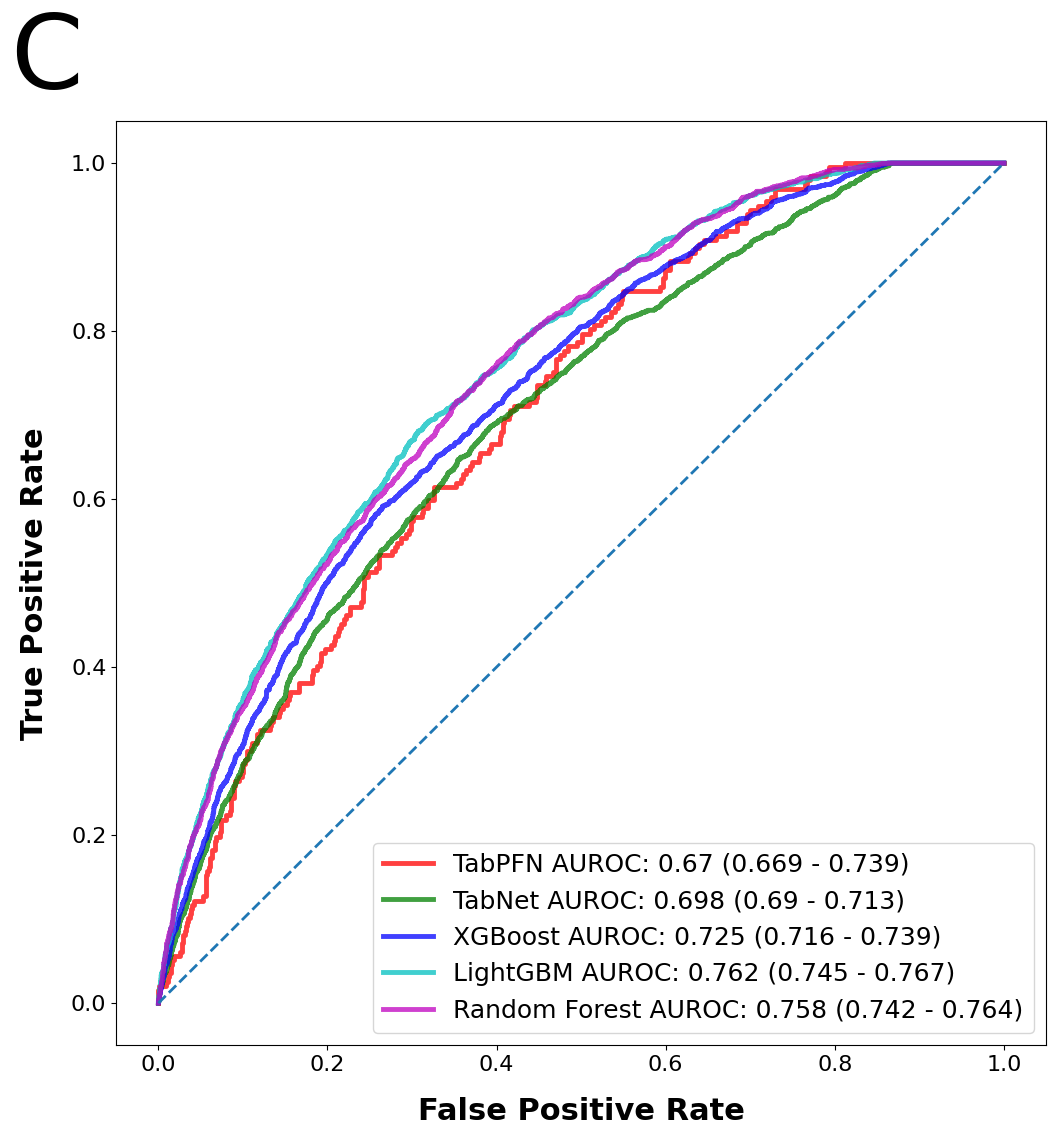

In [51]:
#Plot ROC curve.

f = pyplot.figure()
f.set_figwidth(12)
f.set_figheight(12)

tabpfn_fpr, tabpfn_tpr, _ = roc_curve(tabpfn_y_test, probs_tabpfn)
tabpfn_label = 'TabPFN AUROC: ' + tabpfn_auroc_str
pyplot.plot(tabpfn_fpr, tabpfn_tpr, label = tabpfn_label, color = 'r', linewidth = 3.5, alpha = 0.75)

tabnet_fpr, tabnet_tpr, _ = roc_curve(y_test, probs_tabnet)
tabnet_label = 'TabNet AUROC: ' + tabnet_auroc_str
pyplot.plot(tabnet_fpr, tabnet_tpr, label = tabnet_label, color = 'g', linewidth = 3.5, alpha = 0.75)

xgb_fpr, xgb_tpr, _ = roc_curve(y_test, probs_xgb)
xgb_label = 'XGBoost AUROC: ' + xgb_auroc_str
pyplot.plot(xgb_fpr, xgb_tpr, label = xgb_label, color = 'b', linewidth = 3.5, alpha = 0.75)

lgb_fpr, lgb_tpr, _ = roc_curve(y_test, probs_lgb)
lgb_label = 'LightGBM AUROC: ' + lgb_auroc_str
pyplot.plot(lgb_fpr, lgb_tpr, label = lgb_label, color='c', linewidth = 3.5, alpha = 0.75)

rf_fpr, rf_tpr, _ = roc_curve(y_test, probs_rf)
rf_label = 'Random Forest AUROC: ' + rf_auroc_str
pyplot.plot(rf_fpr, rf_tpr, label = rf_label, color = 'm', linewidth = 3.5, alpha = 0.75)

pyplot.plot([0, 1], [0, 1], linestyle = '--', linewidth=2)

pyplot.title('C', x = -0.075, y = 1.005, fontsize = 75, pad = 20)
pyplot.xlabel('False Positive Rate', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.ylabel('True Positive Rate', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.tick_params(axis="y",direction="out", labelsize = 16)
pyplot.tick_params(axis="x",direction="out", labelsize = 16)

leg = pyplot.legend(loc = 'lower right', fontsize = 18)

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/los_roc.png', dpi=300)
pyplot.show()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


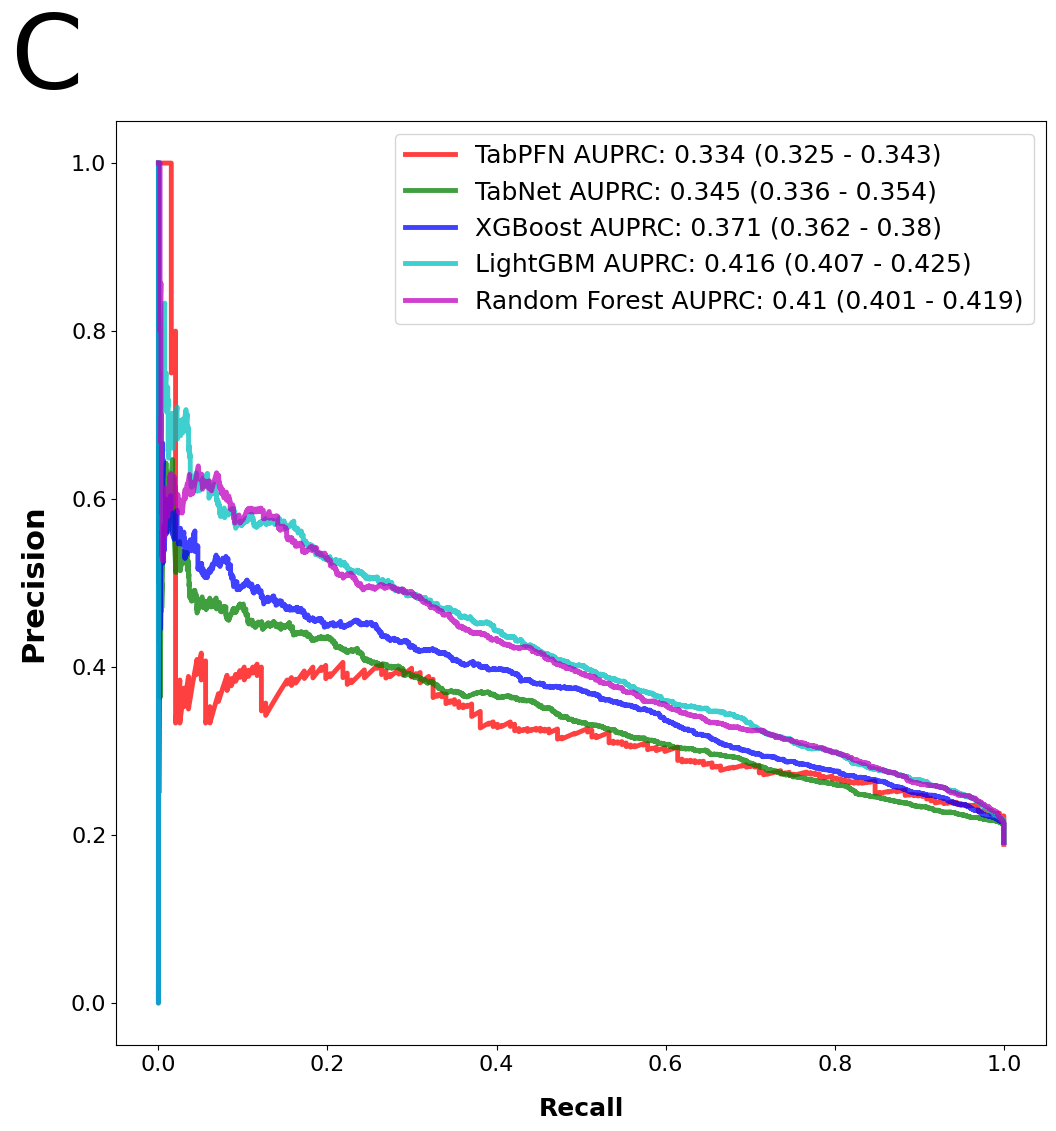

In [52]:
#Plot PR curve.

f = pyplot.figure()
f.set_figwidth(12)
f.set_figheight(12)

tabpfn_label = 'TabPFN AUPRC: ' + tabpfn_auprc_str
tabnet_label = 'TabNet AUPRC: ' + tabnet_auprc_str
xgb_label = 'XGBoost AUPRC: ' + xgb_auprc_str
lgb_label = 'LightGBM AUPRC: ' + lgb_auprc_str
rf_label = 'Random Forest AUPRC: ' + rf_auprc_str

pyplot.plot(tabpfn_recall_curve, tabpfn_precision_curve, label = tabpfn_label, color = 'r', linewidth = 3.5, alpha = 0.75)
pyplot.plot(tabnet_recall_curve, tabnet_precision_curve, label = tabnet_label, color = 'g', linewidth = 3.5, alpha = 0.75)
pyplot.plot(xgb_recall_curve, xgb_precision_curve, label = xgb_label, color = 'b', linewidth = 3.5, alpha = 0.75)
pyplot.plot(lgb_recall_curve, lgb_precision_curve, label = lgb_label, color = 'c', linewidth = 3.5, alpha = 0.75)
pyplot.plot(rf_recall_curve, rf_precision_curve, label = rf_label, color = 'm', linewidth = 3.5, alpha = 0.75)

pyplot.title('C', x = -0.075, y = 1.005, fontsize = 75, pad = 20)
pyplot.xlabel('Recall', fontsize = 18, fontweight = 'heavy', labelpad = 16)
pyplot.ylabel('Precision', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.tick_params(axis="y",direction="out", labelsize = 16)
pyplot.tick_params(axis="x",direction="out", labelsize = 16)

leg = pyplot.legend(loc = 'upper right', fontsize = 18)

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/los_prc.png', dpi=300)
pyplot.show()

# Results Summary

In [53]:
#Calculate means.

mean_precision = round((sum(list([tabpfn_precision, tabnet_precision, xgb_precision, lgb_precision, rf_precision]))/5), 3)
mean_precision_ci_lower = round((sum(list([tabpfn_precision_ci_lower, tabnet_precision_ci_lower, xgb_precision_ci_lower, lgb_precision_ci_lower, rf_precision_ci_lower]))/5), 3)
mean_precision_ci_upper = round((sum(list([tabpfn_precision_ci_upper, tabnet_precision_ci_upper, xgb_precision_ci_upper, lgb_precision_ci_upper, rf_precision_ci_upper]))/5), 3)
mean_precision_str = str(mean_precision) + ' (' + str(mean_precision_ci_lower) + ' - ' + str(mean_precision_ci_upper) + ')'

mean_recall = round((sum(list([tabpfn_recall, tabnet_recall, xgb_recall, lgb_recall, rf_recall]))/5), 3)
mean_recall_ci_lower = round((sum(list([tabpfn_recall_ci_lower, tabnet_recall_ci_lower, xgb_recall_ci_lower, lgb_recall_ci_lower, rf_recall_ci_lower]))/5), 3)
mean_recall_ci_upper = round((sum(list([tabpfn_recall_ci_upper, tabnet_recall_ci_upper, xgb_recall_ci_upper, lgb_recall_ci_upper, rf_recall_ci_upper]))/5), 3)
mean_recall_str = str(mean_recall) + ' (' + str(mean_recall_ci_lower) + ' - ' + str(mean_recall_ci_upper) + ')'

mean_auprc = round((sum(list([tabpfn_auprc, tabnet_auprc, xgb_auprc, lgb_auprc, rf_auprc]))/5), 3)
mean_auprc_ci_lower = round((sum(list([tabpfn_auprc_ci_lower, tabnet_auprc_ci_lower, xgb_auprc_ci_lower, lgb_auprc_ci_lower, rf_auprc_ci_lower]))/5), 3)
mean_auprc_ci_upper = round((sum(list([tabpfn_auprc_ci_upper, tabnet_auprc_ci_upper, xgb_auprc_ci_upper, lgb_auprc_ci_upper, rf_auprc_ci_upper]))/5), 3)
mean_auprc_str = str(mean_auprc) + ' (' + str(mean_auprc_ci_lower) + ' - ' + str(mean_auprc_ci_upper) + ')'

mean_accuracy = round((sum(list([tabpfn_accuracy, tabnet_accuracy, xgb_accuracy, lgb_accuracy, rf_accuracy]))/5), 3)
mean_accuracy_ci_lower = round((sum(list([tabpfn_accuracy_ci_lower, tabnet_accuracy_ci_lower, xgb_accuracy_ci_lower, lgb_accuracy_ci_lower, rf_accuracy_ci_lower]))/5), 3)
mean_accuracy_ci_upper = round((sum(list([tabpfn_accuracy_ci_upper, tabnet_accuracy_ci_upper, xgb_accuracy_ci_upper, lgb_accuracy_ci_upper, rf_accuracy_ci_upper]))/5), 3)
mean_accuracy_str = str(mean_accuracy) + ' (' + str(mean_accuracy_ci_lower) + ' - ' + str(mean_accuracy_ci_upper) + ')'

mean_auroc = round((sum(list([tabpfn_auroc, tabnet_auroc, xgb_auroc, lgb_auroc, rf_auroc]))/5), 3)
mean_auroc_ci_lower = round((sum(list([tabpfn_auroc_ci_lower, tabnet_auroc_ci_lower, xgb_auroc_ci_lower, lgb_auroc_ci_lower, rf_auroc_ci_lower]))/5), 3)
mean_auroc_ci_upper = round((sum(list([tabpfn_auroc_ci_upper, tabnet_auroc_ci_upper, xgb_auroc_ci_upper, lgb_auroc_ci_upper, rf_auroc_ci_upper]))/5), 3)
mean_auroc_str = str(mean_auroc) + ' (' + str(mean_auroc_ci_lower) + ' - ' + str(mean_auroc_ci_upper) + ')'

mean_brier = round((sum(list([tabpfn_brier, tabnet_brier, xgb_brier, lgb_brier, rf_brier]))/5), 3)
mean_brier_ci_lower = round((sum(list([tabpfn_brier_ci_lower, tabnet_brier_ci_lower, xgb_brier_ci_lower, lgb_brier_ci_lower, rf_brier_ci_lower]))/5), 3)
mean_brier_ci_upper = round((sum(list([tabpfn_brier_ci_upper, tabnet_brier_ci_upper, xgb_brier_ci_upper, lgb_brier_ci_upper, rf_brier_ci_upper]))/5), 3)
mean_brier_str = str(mean_brier) + ' (' + str(mean_brier_ci_lower) + ' - ' + str(mean_brier_ci_upper) + ')'

mean_results = [mean_precision_str, mean_recall_str, mean_auprc_str, mean_accuracy_str, mean_auroc_str, mean_brier_str]

In [54]:
results = {'TabPFN':tabpfn_results, 'TabNet':tabnet_results, 'XGBoost':xgb_results, 'LightGBM':lgb_results, 'Random Forest':rf_results, 'Mean':mean_results}

results = pd.DataFrame(results, columns = ['TabPFN', 'TabNet', 'XGBoost', 'LightGBM', 'Random Forest', 'Mean'])

results

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
_PyDriveImportHook.find_spec() not found; falling back to find_module()
_OpenCVImportHook.find_spec() not found; falling back to find_module()
_BokehImportHook.find_spec() not found; falling back to find_module()
_AltairImportHook.find_spec() not found; falling back to find_module()
APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
_PyDriveImportHook.find_spec() not found; falling back to find_module()
_OpenCVImportHook.find_spec() not found; falling back to find_module()
_BokehImportHook.find_spec() not found; falling back to find_module()
_AltairImportHook.find_spec() not found; falling back to find_module()


TabPFN                 TabNet                XGBoost  \
0   0.772 (0.764 - 0.78)  0.774 (0.766 - 0.782)  0.781 (0.773 - 0.789)   
1  0.662 (0.653 - 0.671)  0.635 (0.626 - 0.644)  0.663 (0.654 - 0.672)   
2  0.334 (0.325 - 0.343)  0.345 (0.336 - 0.354)   0.371 (0.362 - 0.38)   
3   0.641 (0.632 - 0.65)  0.645 (0.636 - 0.654)   0.659 (0.65 - 0.668)   
4   0.67 (0.669 - 0.739)   0.698 (0.69 - 0.713)  0.725 (0.716 - 0.739)   
5  0.144 (0.137 - 0.151)   0.143 (0.136 - 0.15)  0.139 (0.132 - 0.146)   

                LightGBM          Random Forest                   Mean  
0  0.794 (0.786 - 0.802)  0.789 (0.781 - 0.797)   0.782 (0.774 - 0.79)  
1  0.693 (0.684 - 0.702)   0.679 (0.67 - 0.688)  0.666 (0.657 - 0.675)  
2  0.416 (0.407 - 0.425)   0.41 (0.401 - 0.419)  0.375 (0.366 - 0.384)  
3  0.684 (0.675 - 0.693)  0.676 (0.667 - 0.685)   0.661 (0.652 - 0.67)  
4  0.762 (0.745 - 0.767)  0.758 (0.742 - 0.764)  0.723 (0.712 - 0.744)  
5  0.135 (0.128 - 0.142)  0.135 (0.128 - 0.142)  0.139 (0.132 - 0.146)

In [55]:
results = pd.DataFrame({'TabPFN':tabpfn_results, 'TabNet':tabnet_results, 'XGBoost':xgb_results, 'LightGBM':lgb_results, 'Random Forest':rf_results, 'Mean':mean_results})

results = results.T

results.columns = ['Weighted Precision (95% CI)', 'Weighted Recall (95% CI)',  'Weighted AUPRC (95% CI)', 'Balanced Accuracy (95% CI)', 'AUROC (95% CI)', 'Brier Score']

results.to_csv('/content/drive/MyDrive/TQP-atSDH/los_results.csv')

results

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
_PyDriveImportHook.find_spec() not found; falling back to find_module()
_OpenCVImportHook.find_spec() not found; falling back to find_module()
_BokehImportHook.find_spec() not found; falling back to find_module()
_AltairImportHook.find_spec() not found; falling back to find_module()


Weighted Precision (95% CI) Weighted Recall (95% CI)  \
TabPFN               0.772 (0.764 - 0.78)    0.662 (0.653 - 0.671)   
TabNet              0.774 (0.766 - 0.782)    0.635 (0.626 - 0.644)   
XGBoost             0.781 (0.773 - 0.789)    0.663 (0.654 - 0.672)   
LightGBM            0.794 (0.786 - 0.802)    0.693 (0.684 - 0.702)   
Random Forest       0.789 (0.781 - 0.797)     0.679 (0.67 - 0.688)   
Mean                 0.782 (0.774 - 0.79)    0.666 (0.657 - 0.675)   

              Weighted AUPRC (95% CI) Balanced Accuracy (95% CI)  \
TabPFN          0.334 (0.325 - 0.343)       0.641 (0.632 - 0.65)   
TabNet          0.345 (0.336 - 0.354)      0.645 (0.636 - 0.654)   
XGBoost          0.371 (0.362 - 0.38)       0.659 (0.65 - 0.668)   
LightGBM        0.416 (0.407 - 0.425)      0.684 (0.675 - 0.693)   
Random Forest    0.41 (0.401 - 0.419)      0.676 (0.667 - 0.685)   
Mean            0.375 (0.366 - 0.384)       0.661 (0.652 - 0.67)   

                      AUROC (95% CI)            Brier Score  
TabPFN          0.67 (0.669 - 0.739)  0.144 (0.137 - 0.151)  
TabNet          0.698 (0.69 - 0.713)   0.143 (0.136 - 0.15)  
XGBoost        0.725 (0.716 - 0.739)  0.139 (0.132 - 0.146)  
LightGBM       0.762 (0.745 - 0.767)  0.135 (0.128 - 0.142)  
Random Forest  0.758 (0.742 - 0.764)  0.135 (0.128 - 0.142)  
Mean           0.723 (0.712 - 0.744)  0.139 (0.132 - 0.146)

# SHAP Plots

In [56]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width, 
                                    break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=0)

In [57]:
x_test = x_test[x_test['Age'] > 18]
x_test = x_test[x_test['Age'] < 90]

x_test = x_test[x_test['Weight'] > 30]
x_test = x_test[x_test['Weight'] < 250]

x_test = x_test[x_test['Height'] > 100]
x_test = x_test[x_test['Height'] < 220]

x_test = x_test[x_test['Systolic Blood Pressure'] > 50]
x_test = x_test[x_test['Systolic Blood Pressure'] < 250]

x_test = x_test[x_test['Pulse Rate'] > 20]
x_test = x_test[x_test['Pulse Rate'] < 220]

x_test = x_test[x_test['Respiratory Rate'] > 4]
x_test = x_test[x_test['Respiratory Rate'] < 50]

x_test = x_test[x_test['Days from Incident to ED or Hospital Arrival'] > 0]
x_test = x_test[x_test['Days from Incident to ED or Hospital Arrival'] < 14]

In [58]:
x_test_sample = x_test.sample(frac=0.05, random_state=42)
tabpfn_x_test_sample = tabpfn_x_test.sample(frac=0.05, random_state=42)
tabnet_x_test_sample = x_test.sample(frac=0.05, random_state = 31)

feature_names = x_test_sample.columns

In [59]:
#Calculate SHAP values for TabPFN.

tabpfn_explainer = shap.Explainer(tabpfn.predict, tabpfn_x_test_sample)
tabpfn_shap_values = tabpfn_explainer(tabpfn_x_test_sample)

Streaming output truncated to the last 5000 lines.
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify a

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


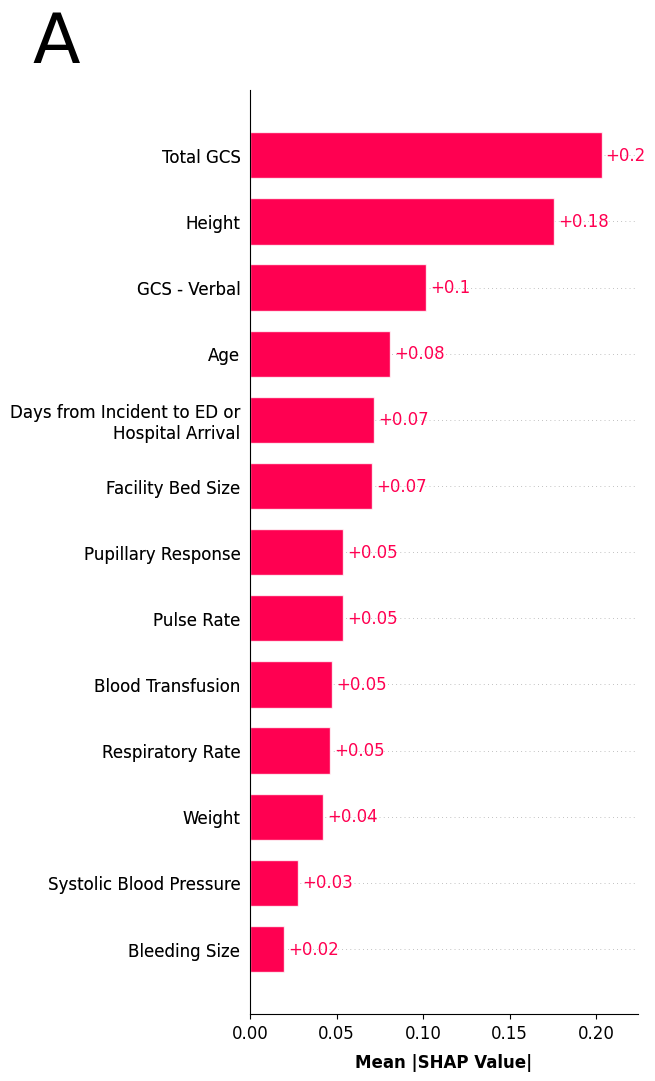

In [60]:
#Plot SHAP bar plot for TabPFN.

shap.plots.bar(tabpfn_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('A', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/los_shap_tabpfn.png', dpi=300, bbox_inches='tight')

In [61]:
#Calculate SHAP values for TabNet.

tabnet_explainer = shap.Explainer(tabnet.predict, x_test_sample.values, feature_names=feature_names)
tabnet_shap_values = tabnet_explainer(x_test_sample.values)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check th

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


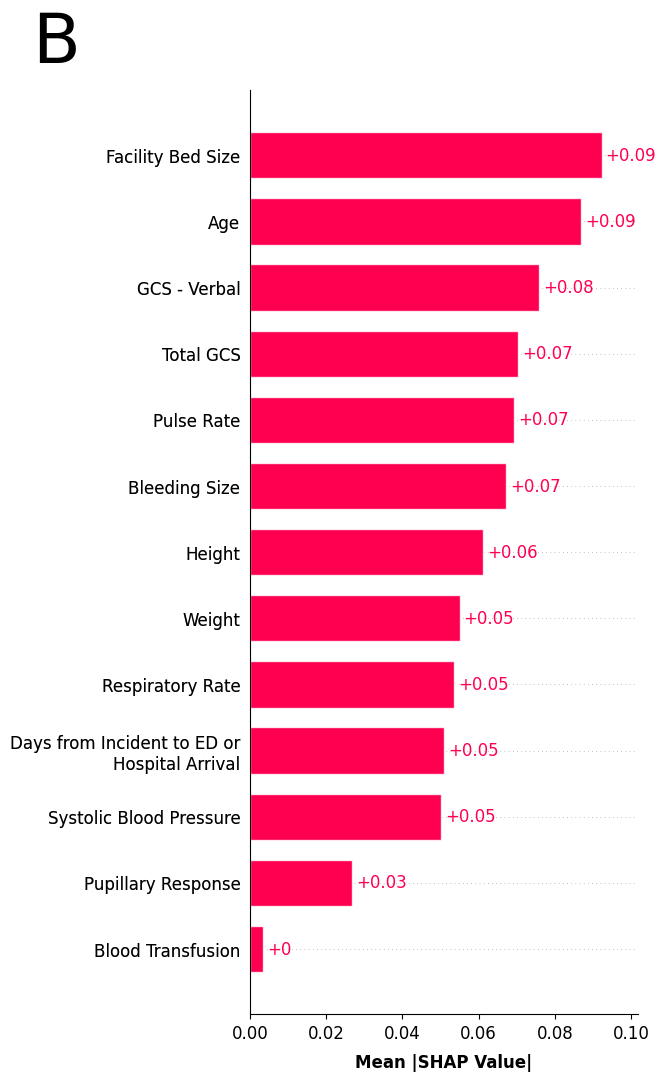

In [62]:
#Plot SHAP bar plot for TabNet.

shap.plots.bar(tabnet_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('B', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/los_shap_tabnet.png', dpi=300, bbox_inches='tight')

In [63]:
#Calculate SHAP values for XGBoost.

xgb_explainer = shap.Explainer(xgb.predict, x_test_sample)
xgb_shap_values = xgb_explainer(x_test_sample)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


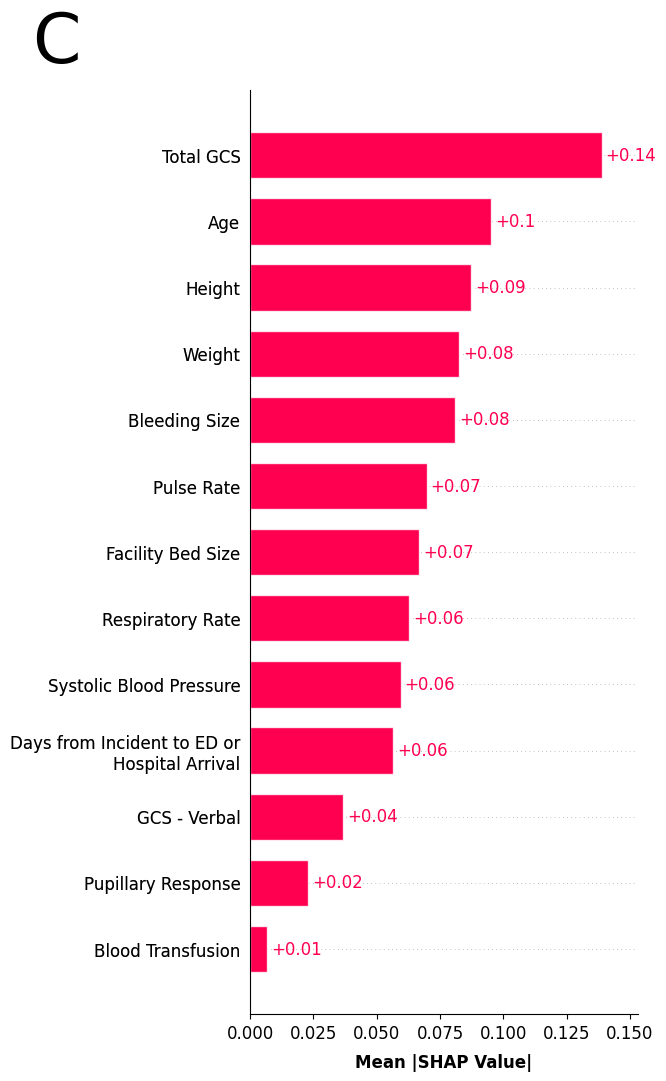

In [64]:
#Plot SHAP bar plot for XGBoost.

shap.plots.bar(xgb_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('C', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/los_shap_xgb.png', dpi=300, bbox_inches='tight')

In [ ]:
#Calculate SHAP values for LightGBM.

lgb_explainer = shap.Explainer(lgb.predict, x_test_sample)
lgb_shap_values = lgb_explainer(x_test_sample)

Streaming output truncated to the last 5000 lines.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.in

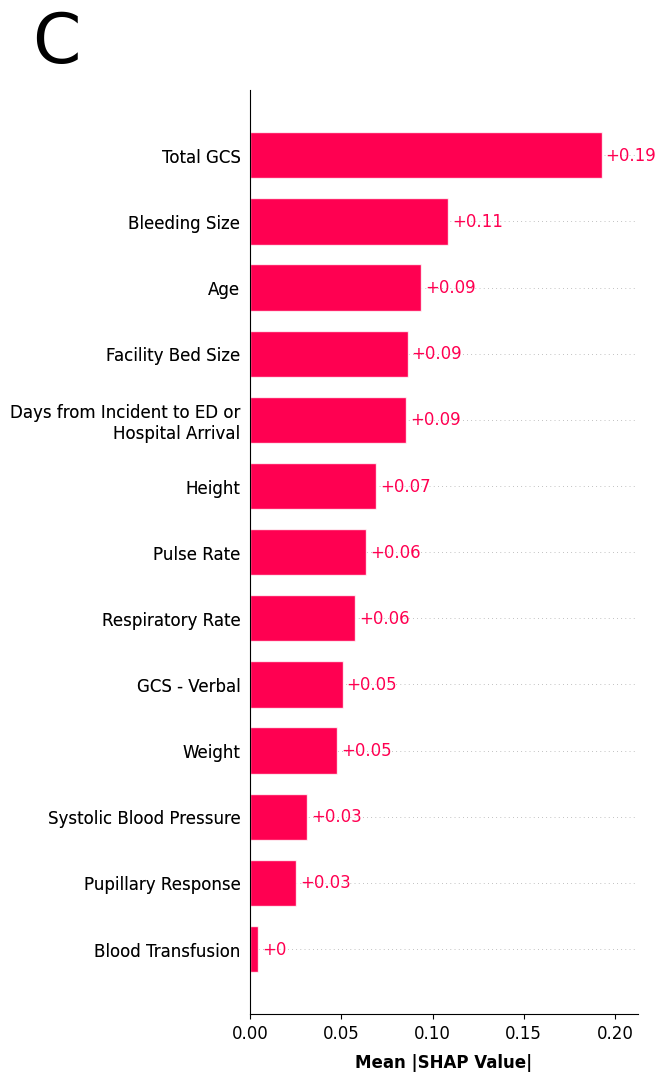

In [ ]:
#Plot SHAP bar plot for LightGBM.

shap.plots.bar(lgb_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('C', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/los_shap_lgb.png', dpi=300, bbox_inches='tight')

In [ ]:
#Calculate SHAP values for Random Forest.

rf_explainer = shap.Explainer(rf.predict, x_test_sample)
rf_shap_values = rf_explainer(x_test_sample)

Streaming output truncated to the last 5000 lines.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.in

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


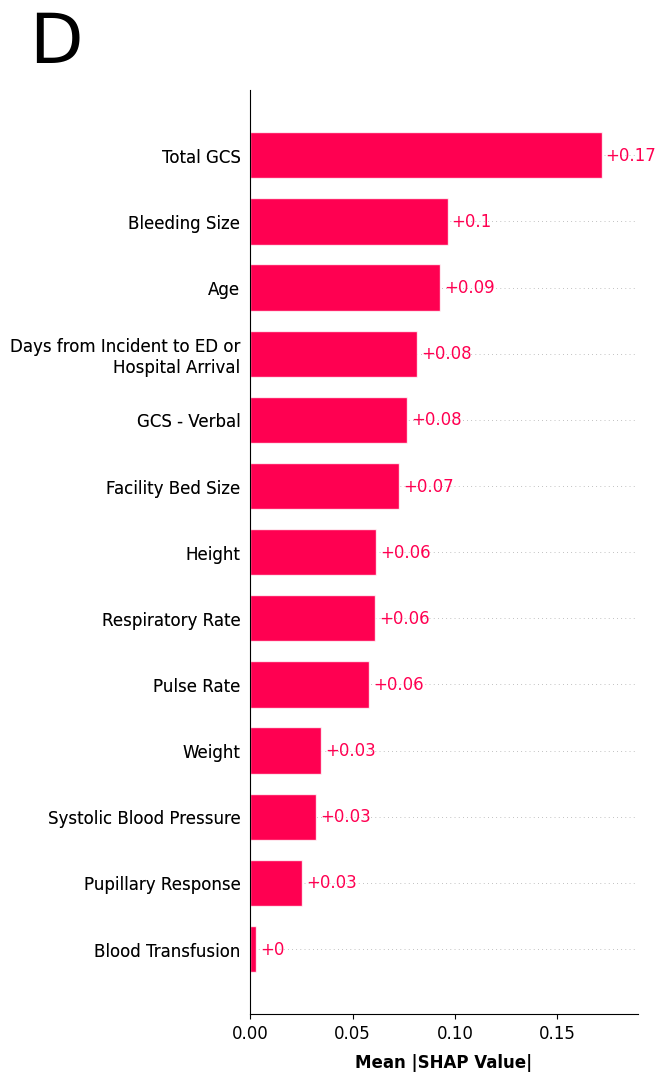

In [ ]:
#Plot SHAP bar plot for Random Forest.

shap.plots.bar(rf_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('D', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/los_shap_rf.png', dpi=300, bbox_inches='tight')

#Partial Dependency Plots

In [ ]:
pyplot.rcParams["figure.figsize"] = (15, 25)
pyplot.rcParams["figure.dpi"] = 300
pyplot.rcParams['axes.labelweight'] = 'bold'
pyplot.rcParams['axes.labelsize'] = 12
pyplot.rcParams['axes.labelpad'] = 6
pyplot.rcParams['font.weight'] = 'normal'
pyplot.rcParams['lines.linewidth'] = 2.5
pyplot.rcParams['xtick.labelsize'] = 8
pyplot.rcParams['ytick.labelsize'] = 8

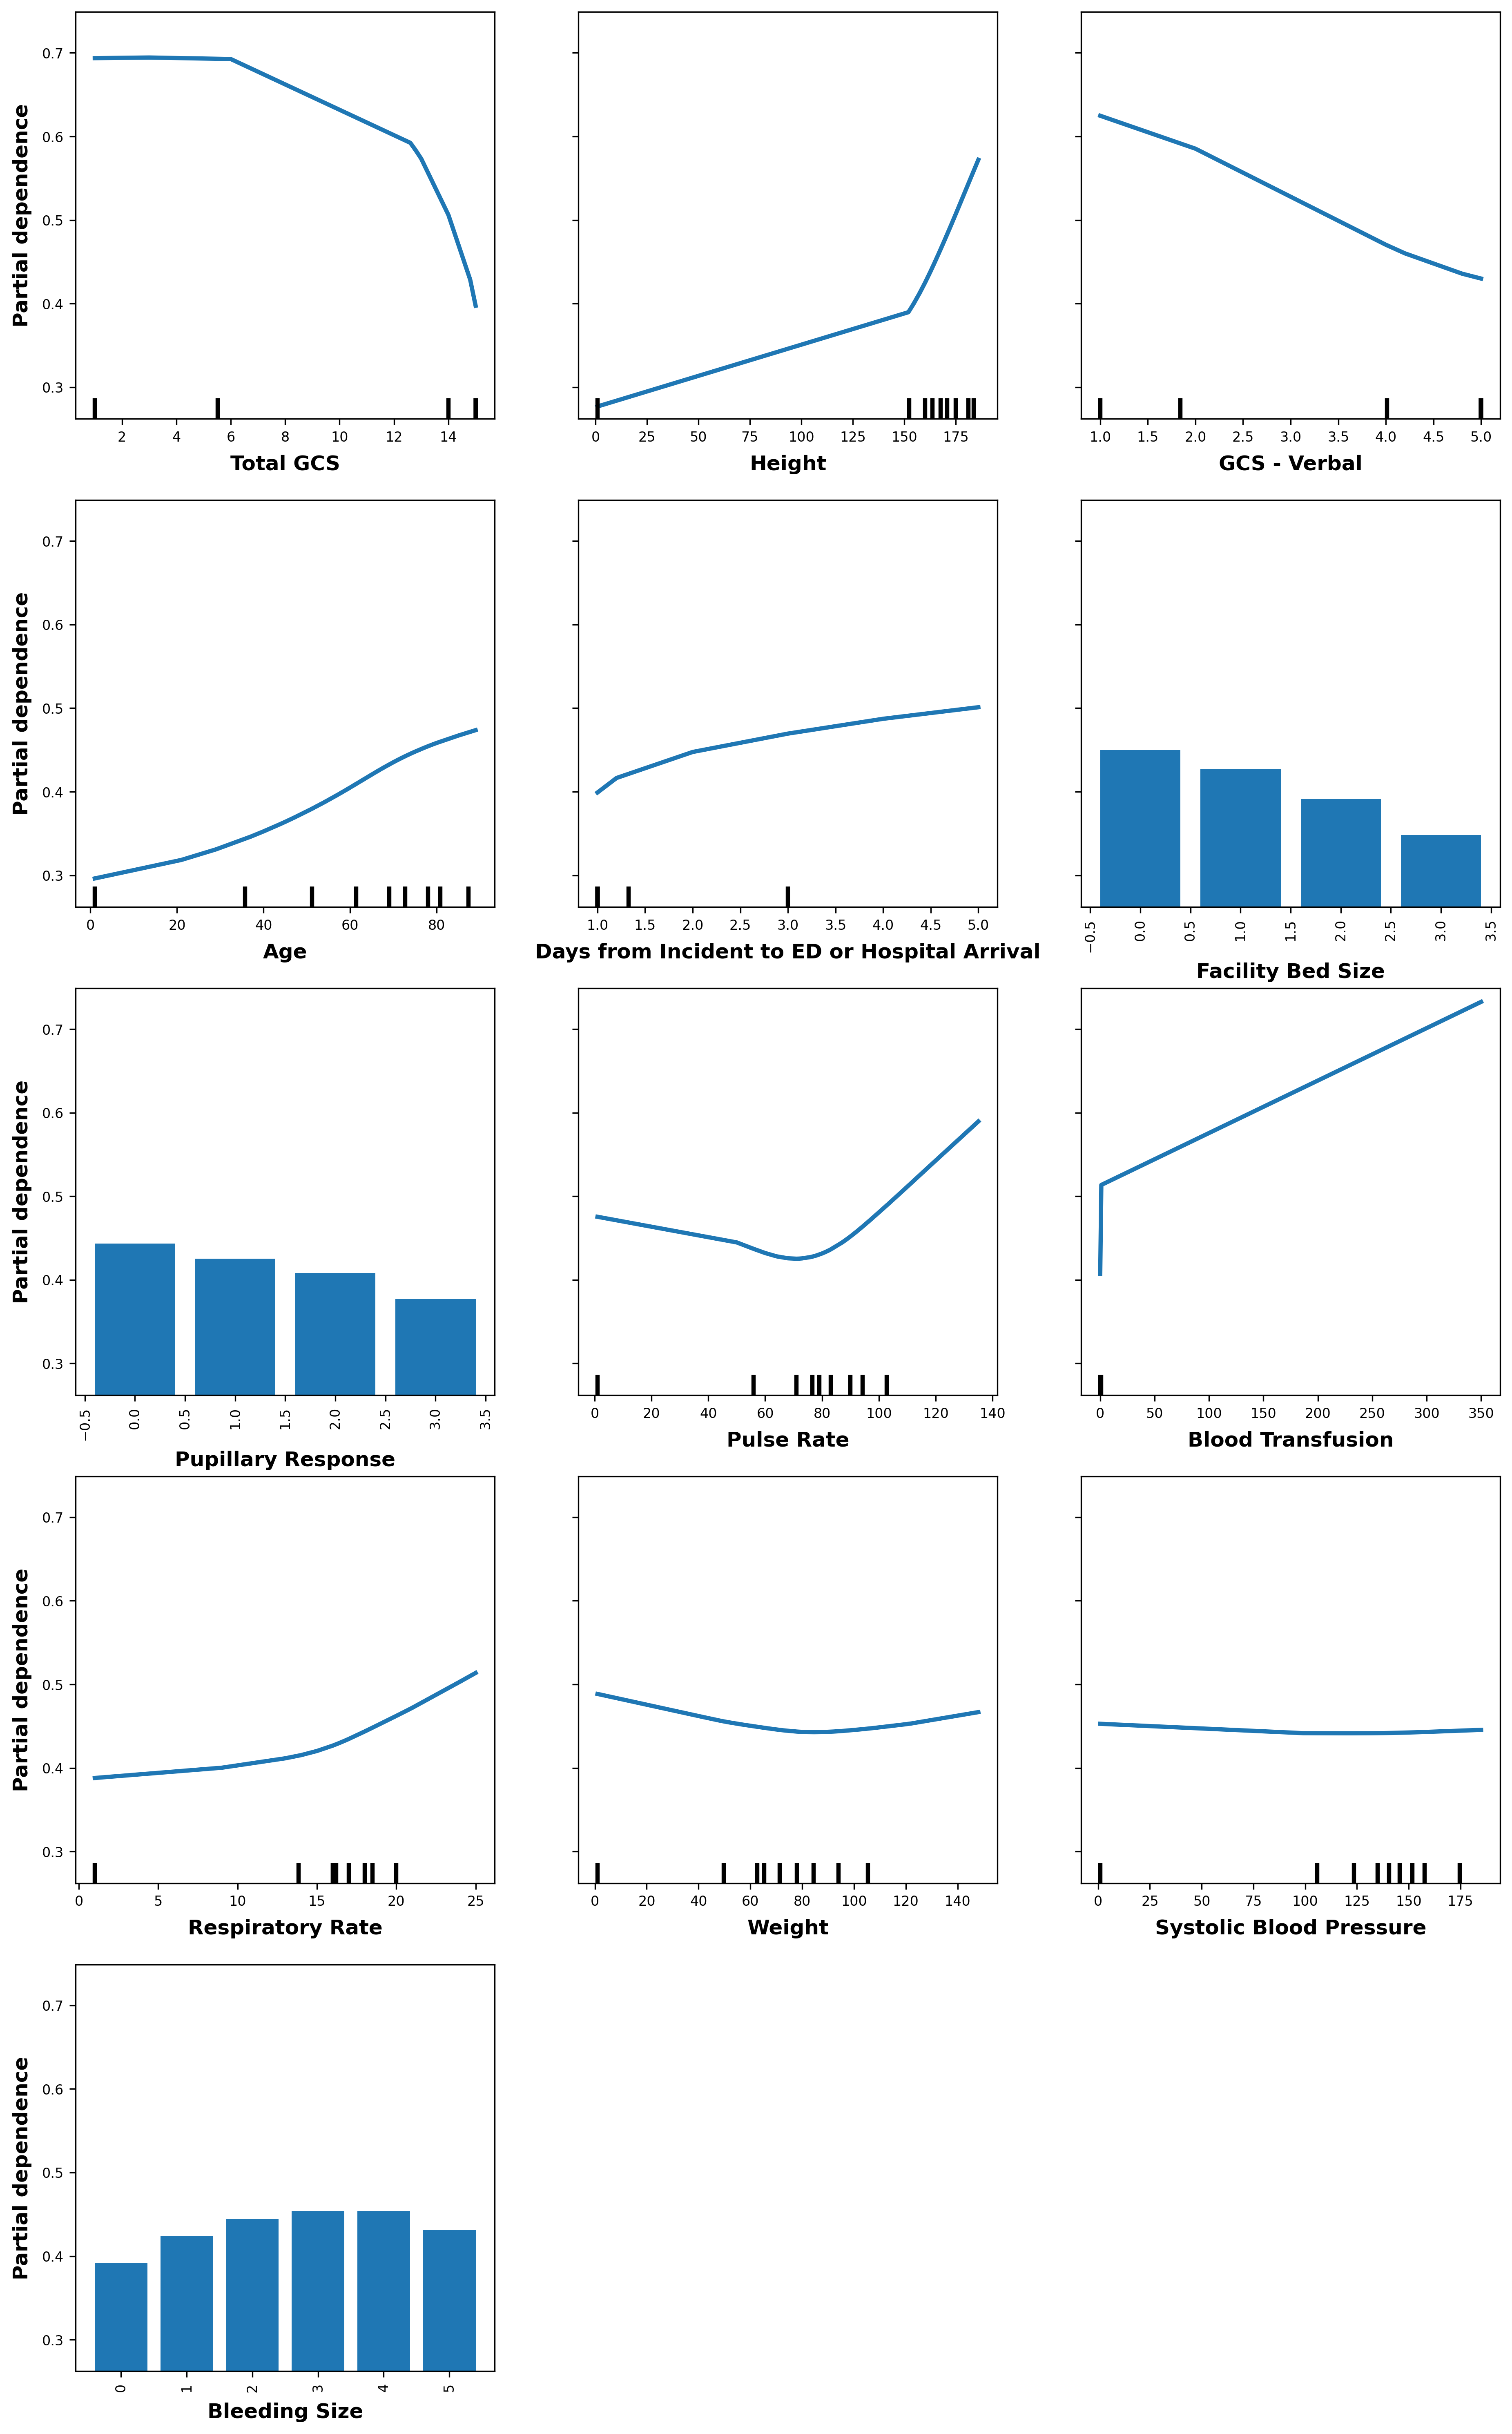

In [ ]:
#Calculate the mean absolute SHAP values for each feature.
tabpfn_mean_abs_shap_values = np.mean(np.abs(tabpfn_shap_values.values), axis=0)

#Create a DataFrame to map feature names to their mean absolute SHAP values.
tabpfn_shap_summary = pd.DataFrame(list(zip(feature_names, tabpfn_mean_abs_shap_values)), columns=['Feature', 'Mean SHAP'])

#Sort the DataFrame by 'Mean SHAP' in descending order.
tabpfn_shap_summary_sorted = tabpfn_shap_summary.sort_values('Mean SHAP', ascending=False)

#Get the names of the features.
tabpfn_features = tabpfn_shap_summary_sorted['Feature'].tolist()

PartialDependenceDisplay.from_estimator(tabpfn, tabpfn_x_test_sample, tabpfn_features, categorical_features = ['Pupillary Response', 'Bleeding Size', 'Facility Bed Size'])
pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/los_pdp_tabpfn.png', dpi=300, bbox_inches='tight')
pyplot.show()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


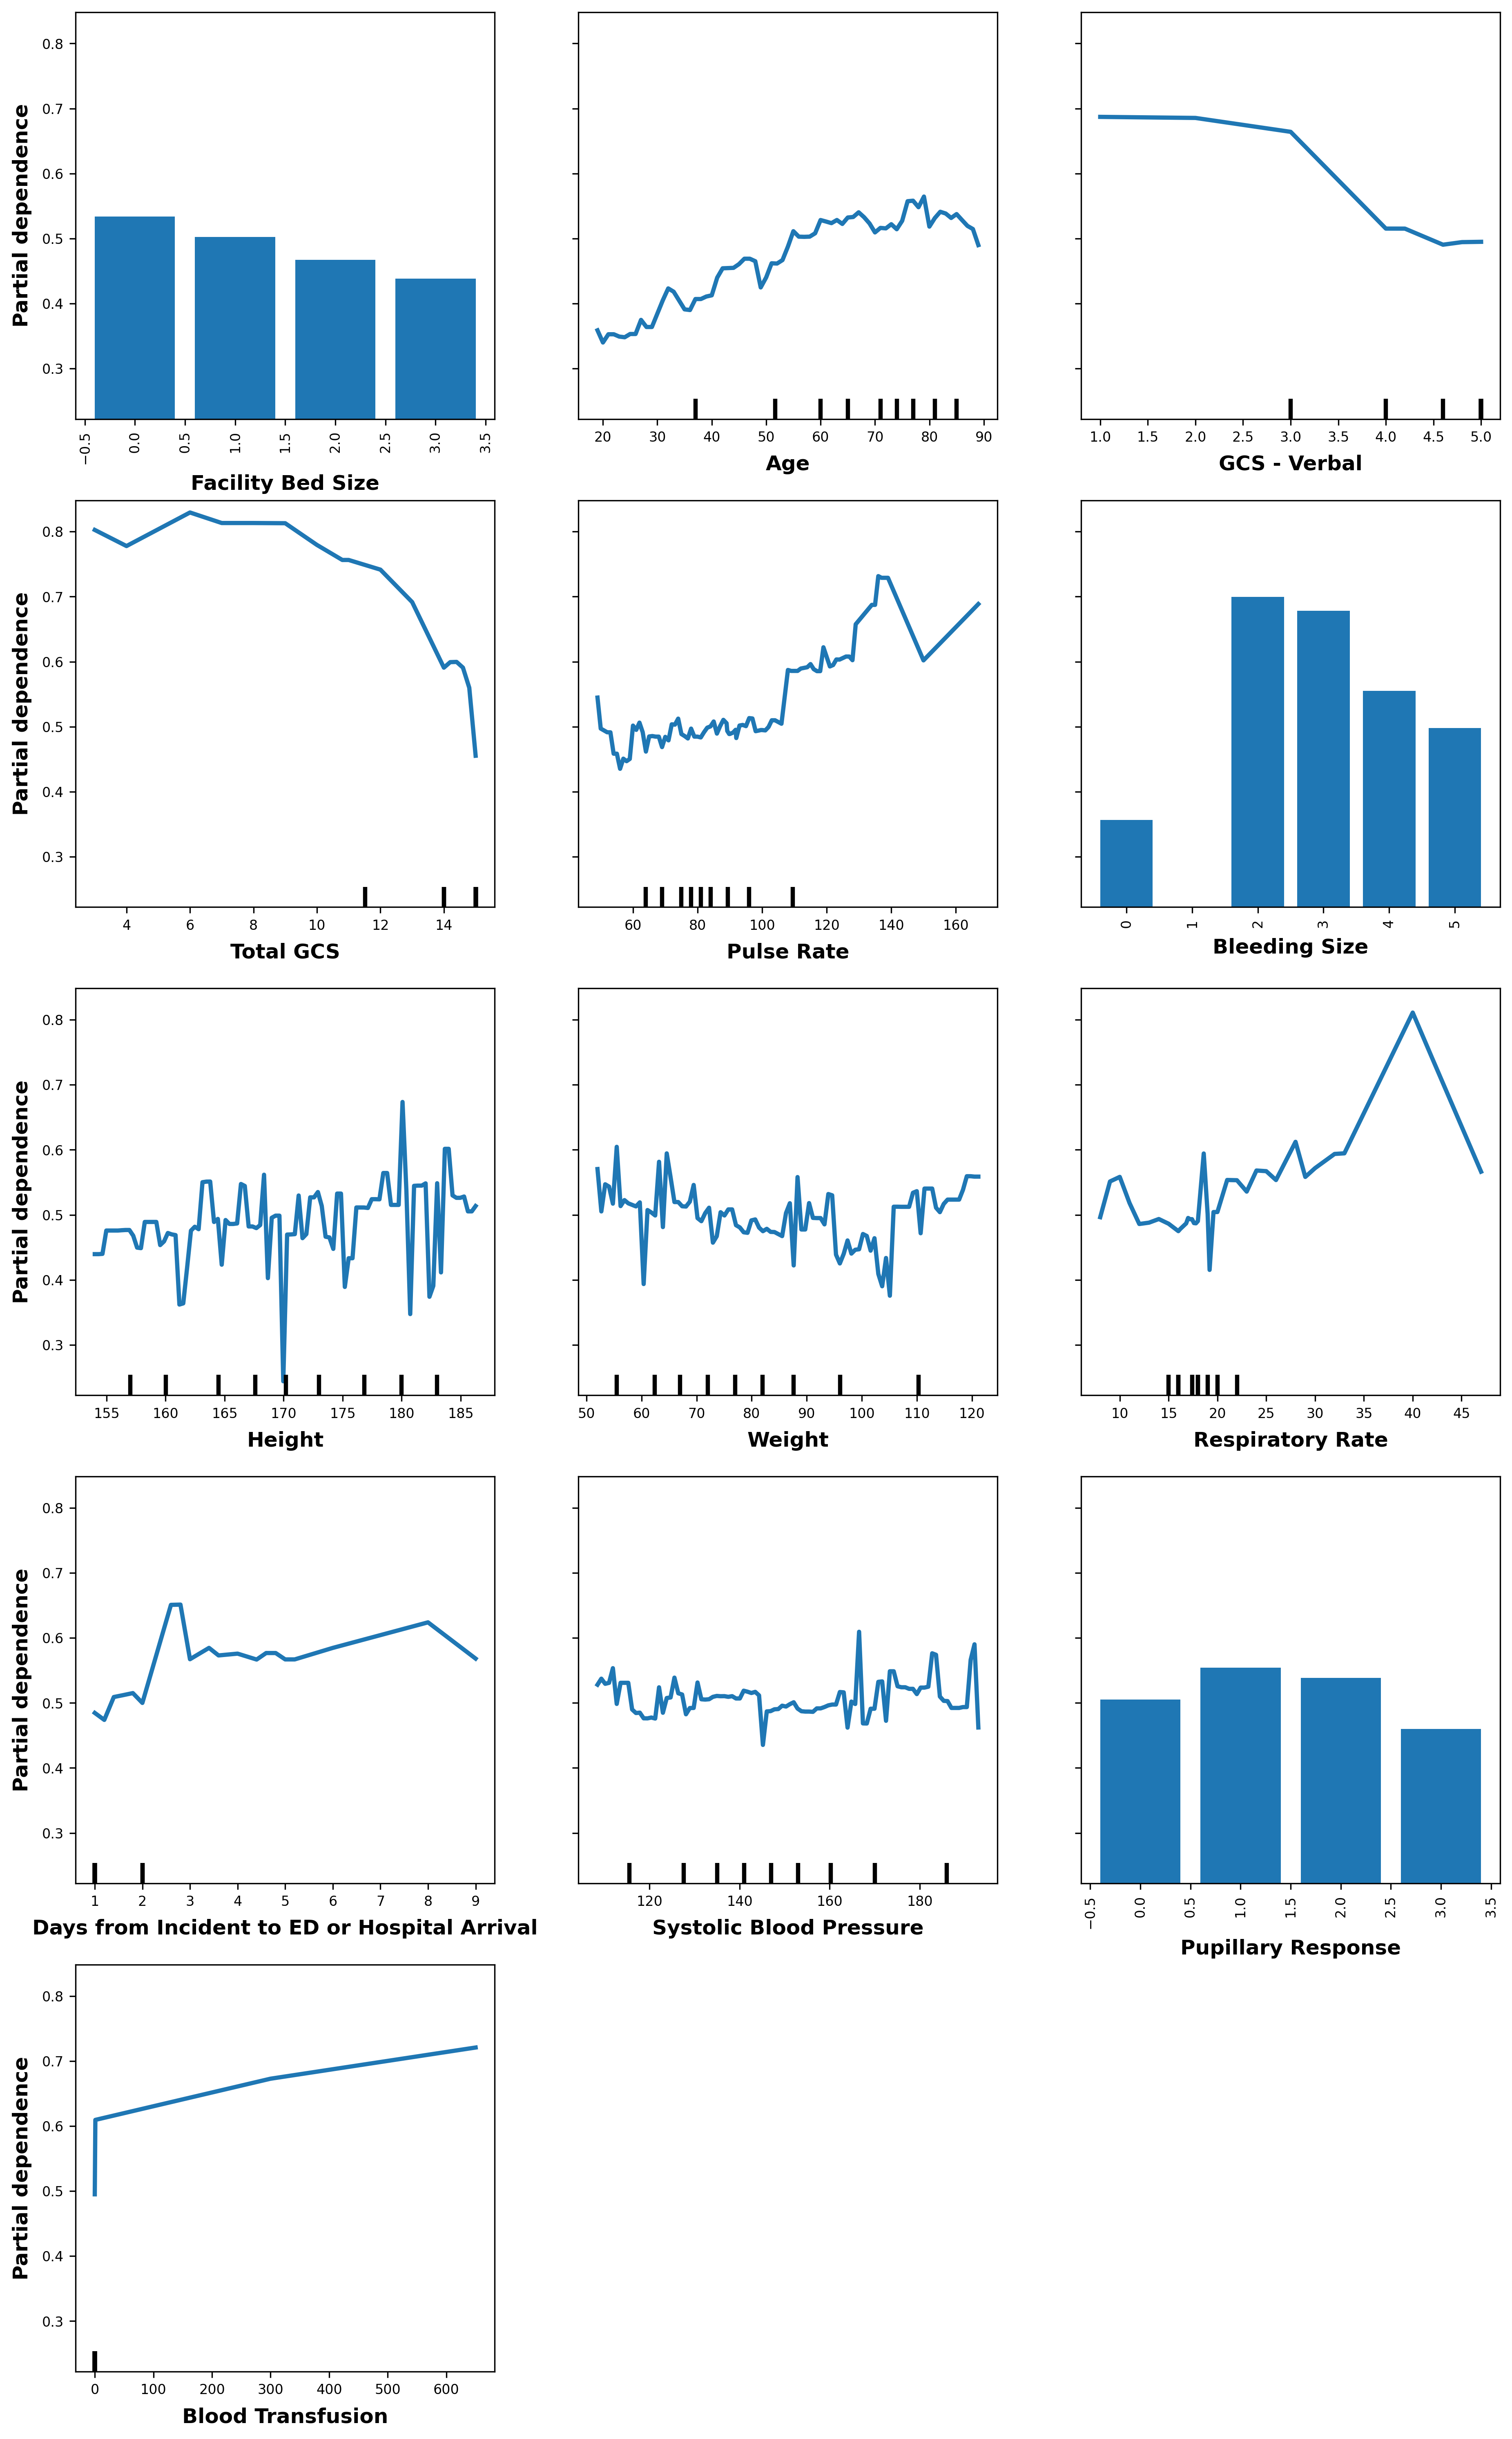

In [ ]:
#Calculate the mean absolute SHAP values for each feature.
tabnet_mean_abs_shap_values = np.mean(np.abs(tabnet_shap_values.values), axis=0)

#Create a DataFrame to map feature names to their mean absolute SHAP values.
tabnet_shap_summary = pd.DataFrame(list(zip(feature_names, tabnet_mean_abs_shap_values)), columns=['Feature', 'Mean SHAP'])

#Sort the DataFrame by 'Mean SHAP' in descending order.
tabnet_shap_summary_sorted = tabnet_shap_summary.sort_values('Mean SHAP', ascending=False)

#Get the names of the features.
tabnet_features = tabnet_shap_summary_sorted['Feature'].tolist()

PartialDependenceDisplay.from_estimator(xgb, tabnet_x_test_sample, tabnet_features, categorical_features = ['Pupillary Response', 'Bleeding Size', 'Facility Bed Size'])
pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/los_pdp_tabnet.png', dpi=300, bbox_inches='tight')
pyplot.show()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


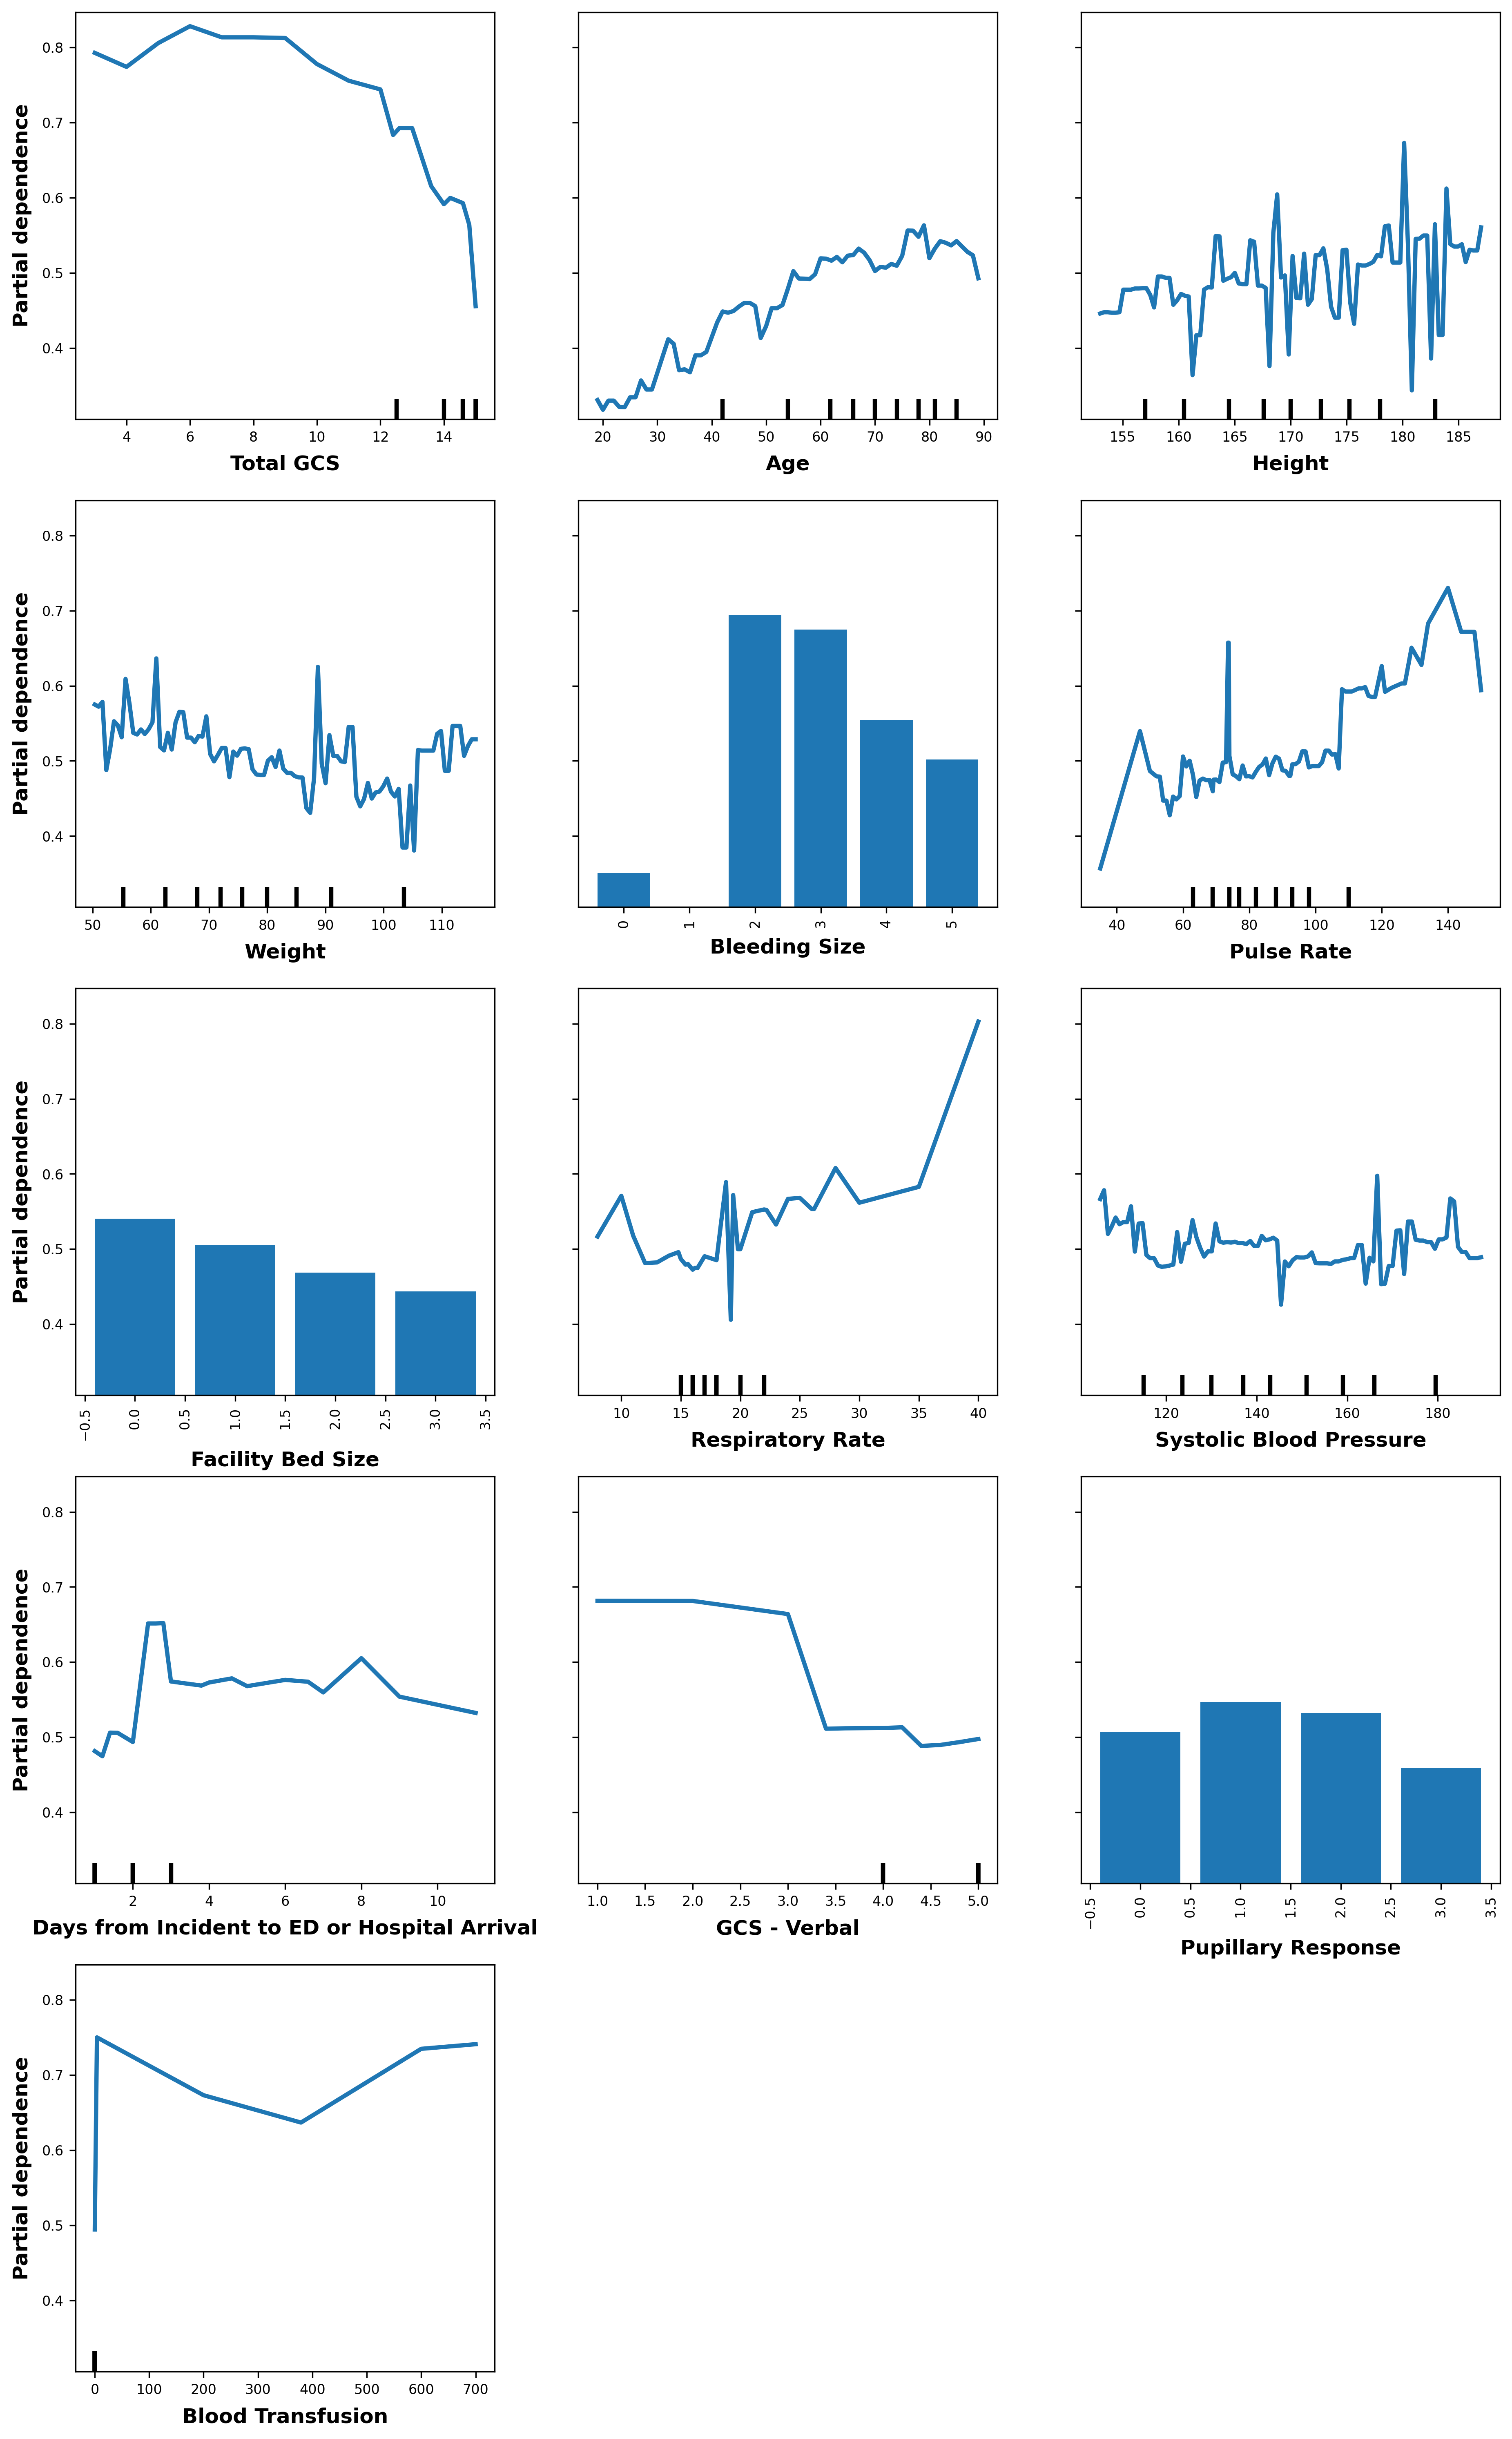

In [ ]:
#Calculate the mean absolute SHAP values for each feature.
xgb_mean_abs_shap_values = np.mean(np.abs(xgb_shap_values.values), axis=0)

#Create a DataFrame to map feature names to their mean absolute SHAP values.
xgb_shap_summary = pd.DataFrame(list(zip(feature_names, xgb_mean_abs_shap_values)), columns=['Feature', 'Mean SHAP'])

#Sort the DataFrame by 'Mean SHAP' in descending order.
xgb_shap_summary_sorted = xgb_shap_summary.sort_values('Mean SHAP', ascending=False)

#Get the names of the features.
xgb_features = xgb_shap_summary_sorted['Feature'].tolist()

PartialDependenceDisplay.from_estimator(xgb, x_test_sample, xgb_features, categorical_features = ['Pupillary Response', 'Bleeding Size', 'Facility Bed Size'])
pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/los_pdp_xgb.png', dpi=300, bbox_inches='tight')
pyplot.show()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


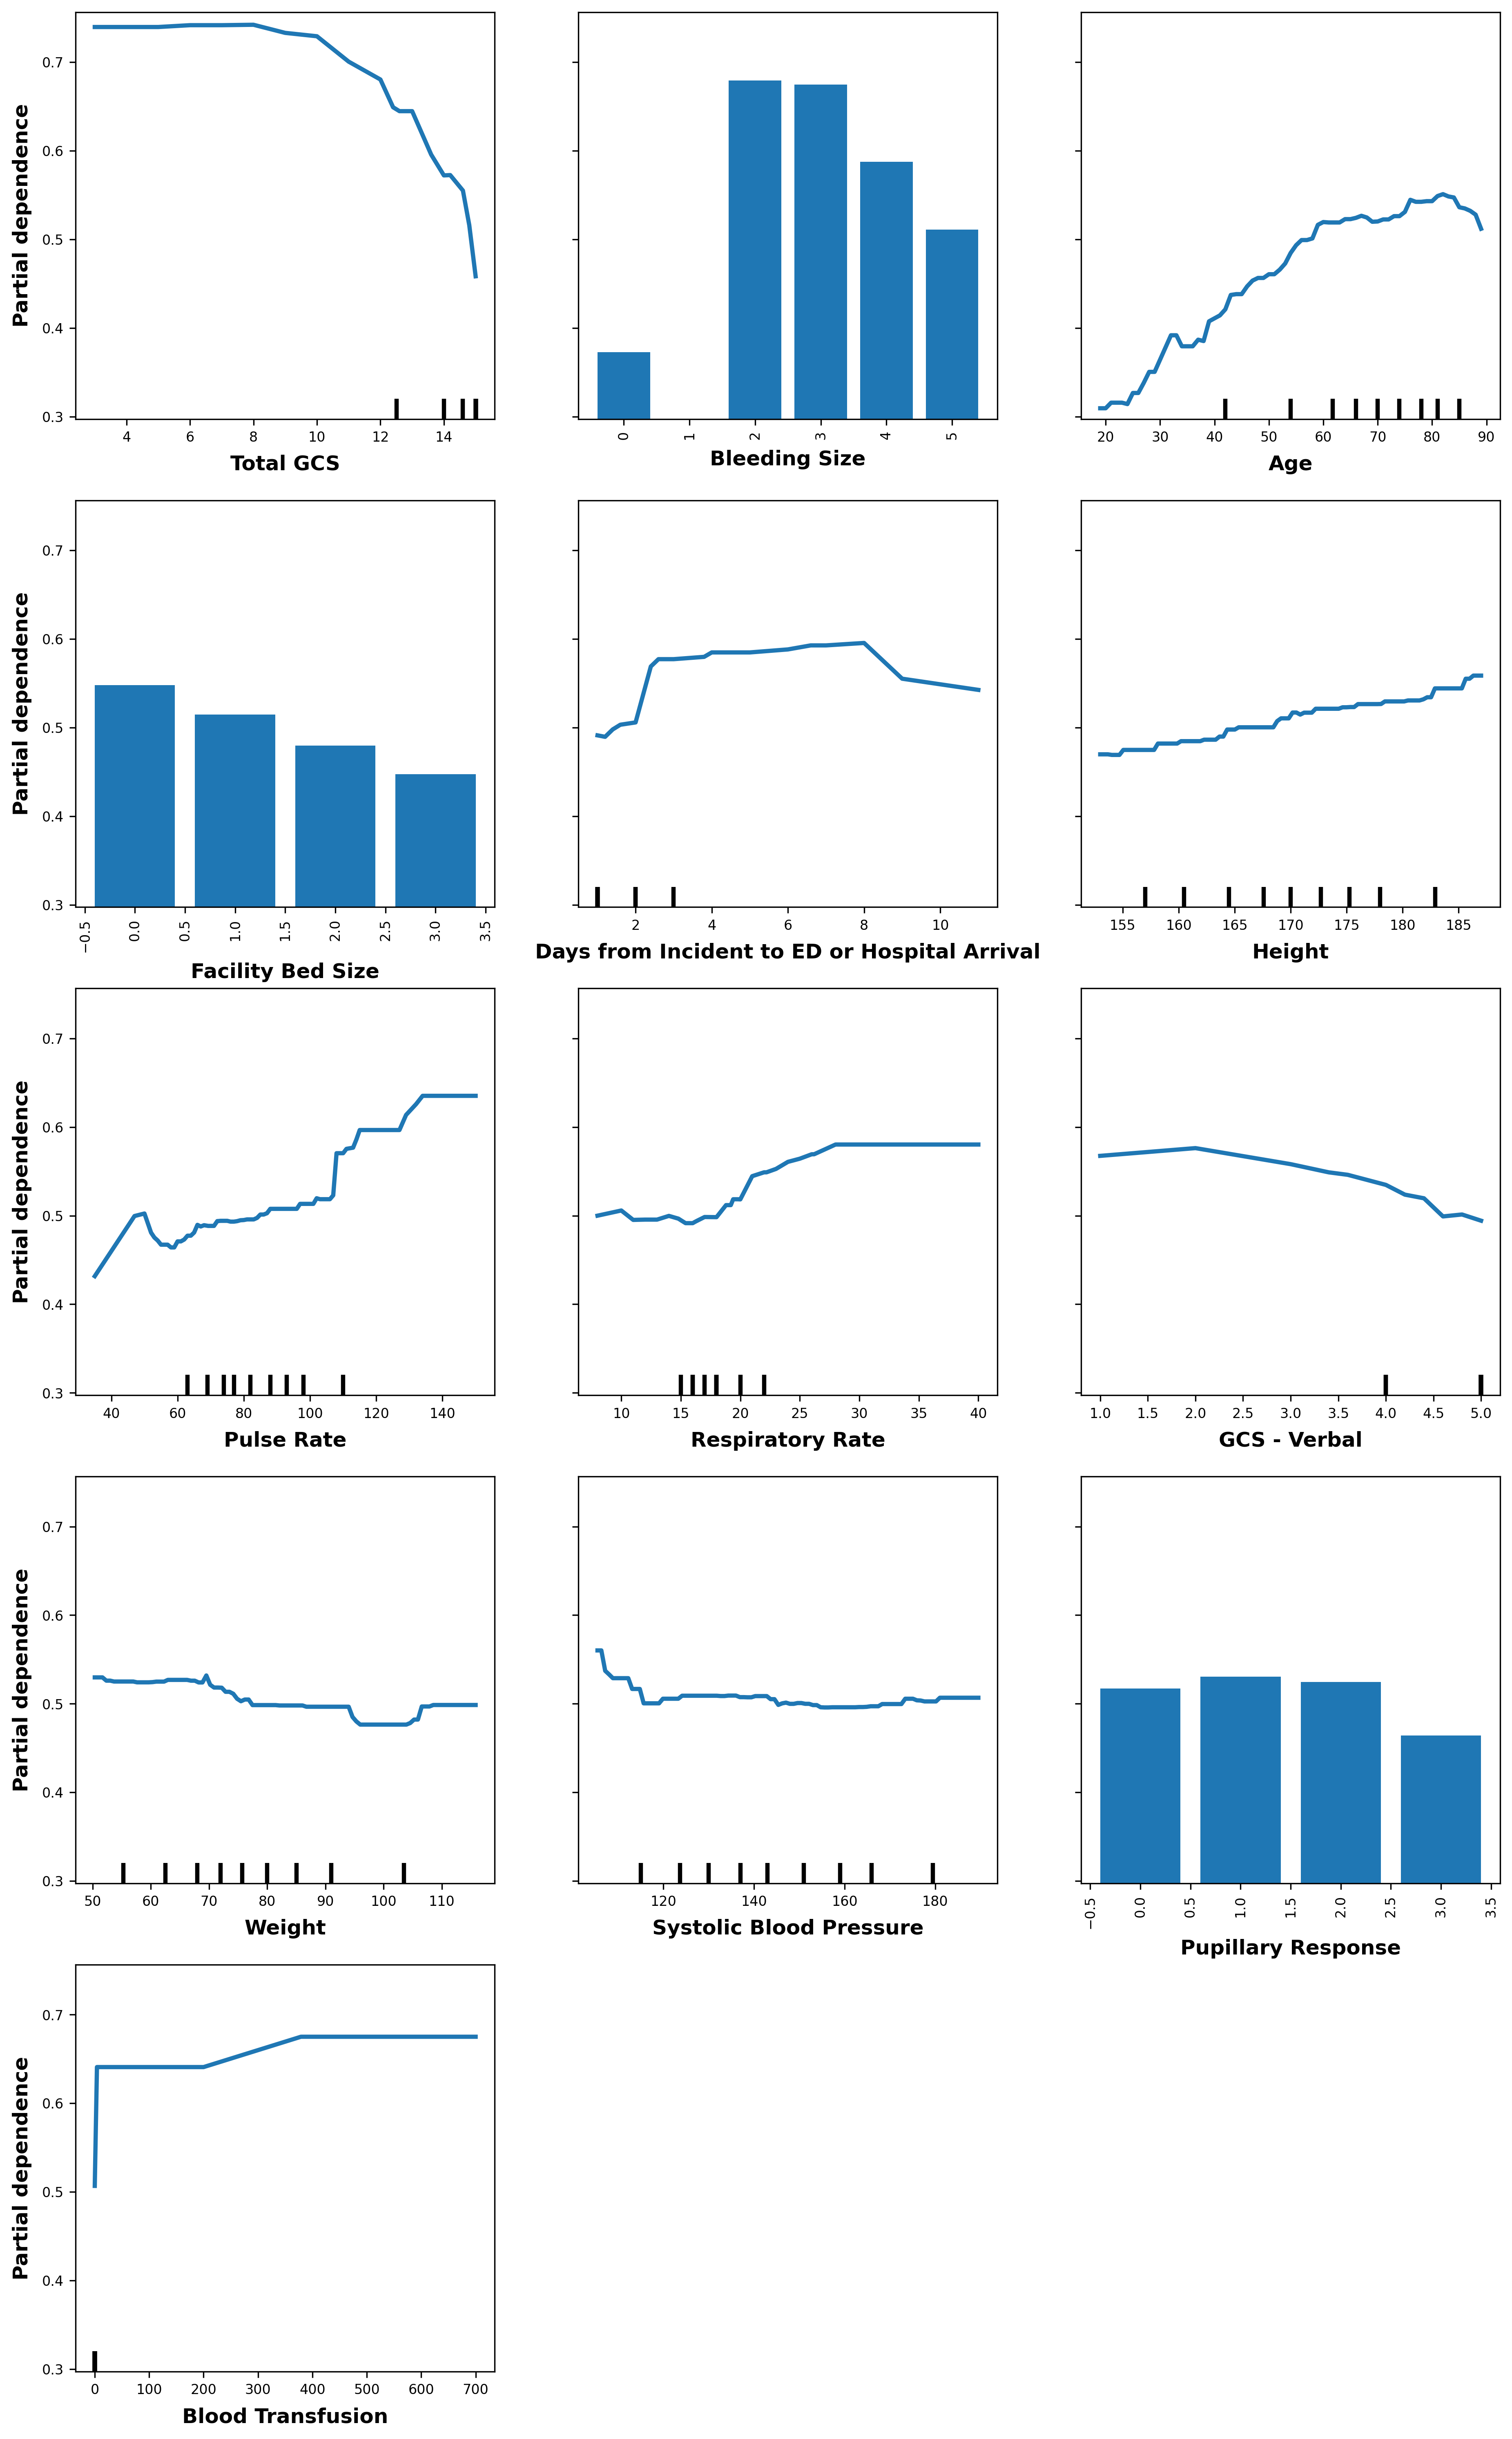

In [ ]:
#Calculate the mean absolute SHAP values for each feature.
lgb_mean_abs_shap_values = np.mean(np.abs(lgb_shap_values.values), axis=0)

#Create a DataFrame to map feature names to their mean absolute SHAP values.
lgb_shap_summary = pd.DataFrame(list(zip(feature_names, lgb_mean_abs_shap_values)), columns=['Feature', 'Mean SHAP'])

#Sort the DataFrame by 'Mean SHAP' in descending order.
lgb_shap_summary_sorted = lgb_shap_summary.sort_values('Mean SHAP', ascending=False)

#Get the names of the features.
lgb_features = lgb_shap_summary_sorted['Feature'].tolist()

PartialDependenceDisplay.from_estimator(lgb, x_test_sample, lgb_features, categorical_features = ['Pupillary Response', 'Bleeding Size', 'Facility Bed Size'])
pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/los_pdp_lgb.png', dpi=300, bbox_inches='tight')
pyplot.show()

In [ ]:
#Calculate the mean absolute SHAP values for each feature.
rf_mean_abs_shap_values = np.mean(np.abs(rf_shap_values.values), axis=0)

#Create a DataFrame to map feature names to their mean absolute SHAP values.
rf_shap_summary = pd.DataFrame(list(zip(feature_names, rf_mean_abs_shap_values)), columns=['Feature', 'Mean SHAP'])

#Sort the DataFrame by 'Mean SHAP' in descending order.
rf_shap_summary_sorted = rf_shap_summary.sort_values('Mean SHAP', ascending=False)

#Get the names of the features.
rf_features = rf_shap_summary_sorted['Feature'].tolist()

PartialDependenceDisplay.from_estimator(rf, x_test_sample, rf_features, categorical_features = ['Pupillary Response', 'Bleeding Size', 'Facility Bed Size'])
pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/los_pdp_rf.png', dpi=300, bbox_inches='tight')
pyplot.show()